# Projet 7: Implémentez un modèle de scoring (feature selection et choix du modèle de scoring)

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement des données](#load)
3. [Sélection des données d'entrainement et de test](#train_test)
4. [Feature selection](#feats)
5. [Traitement des données déséquilibrées](#imbalanced)
6. [Pipeline, optimisation et entrainement des modèles](#pipe)
7. [Choix des scores](#scores)
8. [Modélisations](#model)
    1. [Modèle Baseline: Dummy classifier](#dummy)
    2. [Régression logistique](#reglog)
    3. [LightGBM](#lightgbm)
9. [Sélection du meilleur modèle](#best)
    1. [Définition du seuil de probabilité](#predict_proba)
    2. [Sauvegarde du modèle](#save)
    3. [Features importance](#feat_imp)

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [5]:
# Configuration pour permettre les longues exécutions
import sys
sys.path.insert(0, '..')

# Augmenter le timeout Jupyter pour permettre les longues exécutions
try:
    from IPython.display import display, Markdown
    import IPython
    # Configuration du kernel pour timeout très long (1 heure)
    IPython.get_ipython().kernel.shell.run_cell(
        "%config IPKernelApp.iopub_data_rate_limit=1e10"
    )
    print("✅ Configuration notebook pour longues exécutions activée")
except:
    print("⚠️ Configuration timeout non appliquée (environnement non Jupyter)")


✅ Configuration notebook pour longues exécutions activée


In [6]:
# builtin
import time

# data
import numpy as np
import pandas as pd
import random

# Fonctions personnelles
import fct_eda
import fct_preprocessing


# Update Fonctions personnelles
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2, f_classif

# Balancing data
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as pipe

# Model
from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import set_config
set_config(display='diagram')
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, fbeta_score
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier


# Feature importance locales
from lime import lime_tabular
import shap

import mlflow
import mlflow.sklearn

# Enregistrement du modèle
from pickle import dump
from pickle import load
import dill

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

c:\ashash\7\projet7-scoring-credit\venv\Lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
c:\ashash\7\projet7-scoring-credit\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ashash\7\projet7-scoring-credit\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Configuration Pandas
pd_option_dictionary = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': None,
    'display.float_format' : '{:.2f}'.format,
}

for pat, value in pd_option_dictionary.items():
    pd.set_option(pat, value)

## Chargement des données <a class="anchor" id="load"></a>

In [9]:
df = fct_preprocessing.preprocessing_no_NaN()

Application_train shape: (307505, 64)
Processing application_train fait en 4.0s 
Bureau shape: (305811, 19)
Bureau shape: (305811, 19)
Processing bureau et bureau_balance fait en 14.0s 
Processing bureau et bureau_balance fait en 14.0s 
Previous applications shape: (338857, 150)
Previous applications shape: (338857, 150)
Processing previous_applications fait en 23.0s 
Processing previous_applications fait en 23.0s 
Pos-cash balance shape: (337252, 3)
Pos-cash balance shape: (337252, 3)
Processing POS-CASH balance fait en 5.0s 
Processing POS-CASH balance fait en 5.0s 
Installments payments shape: (339587, 4)
Installments payments shape: (339587, 4)
Processing installments payments fait en 15.0s 
Processing installments payments fait en 15.0s 
Credit card balance shape: (103558, 5)
Credit card balance shape: (103558, 5)
Processing credit card balance fait en 43.0s 
Processing credit card balance fait en 43.0s 


In [10]:
# Vérification que le dataset consolidé ne contient pas de NaN
fct_eda.shape_total_nan(df)

Nombre de lignes: 307505
Nombre de colonnes: 240
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [ ]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,CNT_FAM_MEMBERS_RANGE,AGE,AGE_RANGE,YEARS_EMPLOYED,YEARS_EMPLOYED_RANGE,YEARS_REGISTRATION,YEARS_REGISTRATION_RANGE,HOUR_APPR_PROCESS_START_RANGE,YEARS_ID_PUBLISH,YEARS_ID_PUBLISH_RANGE,YEARS_LAST_PHONE_CHANGE,YEARS_LAST_PHONE_CHANGE_RANGE,CREDIT_DURATION,DEBT_RATIO,PAYMENT_RATE,INCOME_PER_PERSON,INCOME_CREDIT_PERC,CREDIT_GOODS_PERC,CREDIT_DURATION_RANGE,DEBT_RATIO_RANGE,INCOME_PER_PERSON_RANGE,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_YEARS_CREDIT_ENDDATE_MEAN,BURO_YEARS_CREDIT_ENDDATE_MAX,BURO_CREDIT_ACTIVE_Active_SUM,BURO_CREDIT_ACTIVE_Closed_SUM,BURO_CREDIT_ACTIVE_Sold / Bad Debt_SUM,BURO_CREDIT_TYPE_Car loan_SUM,BURO_CREDIT_TYPE_Consumer credit_SUM,BURO_CREDIT_TYPE_Credit card_SUM,BURO_CREDIT_TYPE_Microloan_SUM,BURO_CREDIT_TYPE_Mortgage_SUM,BURO_CREDIT_TYPE_Other_SUM,BURO_STATUS_Between 31 and 120 DPD_SUM_SUM,BURO_STATUS_Closed_SUM_SUM,BURO_STATUS_Max 30 DPD_SUM_SUM,BURO_STATUS_More than 120 DPD or written off_SUM_SUM,PREV_NB_CREDIT,PREV_YEARS_DECISION_MEAN,PREV_CREDIT_DURATION_MEAN,PREV_CREDIT_GOODS_PERC_MEAN,PREV_PAYMENT_RATE_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN,...,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_Repeater_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN,PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN,PREV_NAME_GOODS_CATEGORY_Education_MEAN,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Gardening_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_NAME_GOODS_CATEGORY_House Construction_MEAN,PREV_NAME_GOODS_CATEGORY_Insurance_MEAN,PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN,PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN,PREV_NAME_GOODS_CATEGORY_Medicine_MEAN,PREV_NAME_GOODS_CATEGORY_Mobile_MEAN,PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN,PREV_NAME_GOODS_CATEGORY_Other_MEAN,PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment_MEAN,PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN,PREV_NAME_GOODS_CATEGORY_Weapon_MEAN,PREV_NAME_GOODS_CATEGORY_XNA_MEAN,PREV_NAME_PORTFOLIO_Cards_MEAN,PREV_NAME_PORTFOLIO_Cars_MEAN,PREV_NAME_PORTFOLIO_Cash_MEAN,PREV_NAME_PORTFOLIO_POS_MEAN,PREV_NAME_PORTFOLIO_XNA_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME

## Sélection des données d'entrainement et de test <a class="anchor" id="train_test"></a>

En Machine Learning il ne faut jamais valider un modèle sur les données qui ont servi à son entrainement. Le modèle doit être testé sur des données qu'il n'a jamais vues. On aura ainsi une idée de sa performance future. Le dataset sera mélangé de façon aléatoire avant d'être divisé en deux parties:
- un **train set** dont les données sont utilisées pour **entrainer le modèle** (80% des données)
- un **test set** réservé uniquement à **l'évaluation du modèle** (20% des données)

La séparation du dataset en données d’entrainement et de test va permettre de **détecter de l’overfitting** (modèle trop complexe qui apprend parfaitement les données d’entrainement mais n’arrive pas à généraliser) ou de **l’underfitting** (modèle trop simple ou mal choisi).

In [ ]:
df_feat = df.copy()

In [ ]:
# Définition des features et de la target
col_X = [f for f in df.columns if f not in ['TARGET']]
X = df_feat[col_X]
y = df_feat['TARGET']

In [ ]:
# Liste des variables quantitatives
num_feat = X.select_dtypes(exclude='object').columns.tolist()   

In [ ]:
# OneHotEncoder sur nos variables catégorielles
X, categ_feat = fct_eda.categories_encoder(X, nan_as_category = False)
X.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,CREDIT_DURATION,DEBT_RATIO,PAYMENT_RATE,INCOME_PER_PERSON,INCOME_CREDIT_PERC,CREDIT_GOODS_PERC,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_YEARS_CREDIT_ENDDATE_MEAN,BURO_YEARS_CREDIT_ENDDATE_MAX,BURO_CREDIT_ACTIVE_Active_SUM,BURO_CREDIT_ACTIVE_Closed_SUM,BURO_CREDIT_ACTIVE_Sold / Bad Debt_SUM,BURO_CREDIT_TYPE_Car loan_SUM,BURO_CREDIT_TYPE_Consumer credit_SUM,BURO_CREDIT_TYPE_Credit card_SUM,BURO_CREDIT_TYPE_Microloan_SUM,BURO_CREDIT_TYPE_Mortgage_SUM,BURO_CREDIT_TYPE_Other_SUM,BURO_STATUS_Between 31 and 120 DPD_SUM_SUM,BURO_STATUS_Closed_SUM_SUM,BURO_STATUS_Max 30 DPD_SUM_SUM,BURO_STATUS_More than 120 DPD or written off_SUM_SUM,PREV_NB_CREDIT,PREV_YEARS_DECISION_MEAN,PREV_CREDIT_DURATION_MEAN,PREV_CREDIT_GOODS_PERC_MEAN,PREV_PAYMENT_RATE_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Car repairs_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN,...,PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN,PREV_PRODUCT_COMBINATION_POS other with interest_MEAN,PREV_PRODUCT_COMBINATION_POS others without interest_MEAN,PREV_FLAG_LAST_APPL_PER_CONTRACT_MEAN,APPROVED_SK_ID_PREV_COUNT,APPROVED_YEARS_DECISION_MEAN,APPROVED_CREDIT_DURATION_MEAN,APPROVED_CREDIT_GOODS_PERC_MEAN,APPROVED_PAYMENT_RATE_MEAN,REFUSEDSK_ID_PREV_COUNT,REFUSEDYEARS_DECISION_MEAN,REFUSEDCREDIT_DURATION_MEAN,REFUSEDCREDIT_GOODS_PERC_MEAN,REFUSEDPAYMENT_RATE_MEAN,POS_MONTHS_BALANCE_MEAN,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_NB_CREDIT,INSTAL_DAYS_PAST_DUE_MEAN,INSTAL_DAYS_BEFORE_DUE_MEAN,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_NB_INSTAL,CNT_CHILDREN_> Three children,CNT_CHILDREN_No child,CNT_CHILDREN_One child,CNT_CHILDREN_Two children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Other,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Other,NAME_INCOME_TYPE_Pensioner/Student/Unemployed,NAME_INCOME_TYPE_Private worker,NAME_INCOME_TYPE_Public worker,NAME_EDUCATION_T

In [ ]:
# Jeu d'entrainement (80%) et de validation (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)
print(f"Nb de lignes des données d'entrainement: {len(X_train)} \nNb de lignes des données de validation: {len(X_test)}")

Nb de lignes des données d'entrainement: 246004 
Nb de lignes des données de validation: 61501


In [ ]:
X_train.shape

(246004, 301)

## Feature selection <a class="anchor" id="feats"></a>

Même si nous avons déjà enlevé quelques features quantitatives fortement corrélées entre elles et qualitatives en testant leur association avec la target via Chi2 et Kruskal Wallis, il reste encore beaucoup trop de variables pour les prendre toutes dans notre modèle.

La sélection des caractéristiques est le processus de réduction du nombre de variables d'entrée lors de l'élaboration d'un modèle prédictif. On trouve 2 avantages principaux à réduire le nombre de variables en entrée du modèle:
- **réduire le coût de calcul**
- **améliorer la performance du modèle**

Les méthodes basées sur les statistiques impliquent l'évaluation de la **relation entre chaque variable d'entrée et la variable cible à l'aide de statistiques**. Les variables qui ont la relation la plus forte avec la target seront conservées.

Il existe 2 techniques principales de sélection des caractéristiques: **supervisée** et **non supervisée** (les caractéristiques seront sélectionnées en fonction de la target ou non).

Les méthodes supervisées peuvent être classées en 3 groupes
- **intrinsèques**: algorithmes qui effectuent une **sélection automatique** des caractéristiques pendant l'entrainement
- **wrapper**: méthodes qui évaluent plusieurs modèles à l'aide de procédures qui **ajoutent et/ou suppriment des prédicteurs** afin de trouver la **combinaison optimale** qui **maximise la performance du modèle**.
- **filtres**: sélectionne des sous-ensembles de caractéristiques en fonction de leur **relation avec la cible**.

Nous allons dans un premier temps 
- supprimer les caractéristiques qui n'ont pas de variance c'est à dire les variables qui n'ont qu'une seule et même valeur parmis toutes les observations et n'apportent pas vraiment d'information (produit lors du OneHotEncoding)
- faire une sélection des variables catégorielles puis numériques en nous aidant de **méthodes statistiques**

### VarianceThreshold <a class="anchor" id="Variance"></a>

Nous allons ici supprimer les colonnes sans variance:

In [ ]:
transform = VarianceThreshold(0)

X_train_trans = transform.fit_transform(X_train)
X_test_trans = transform.fit_transform(X_test)

In [ ]:
mask = transform.get_support()
feat_suppr = X.columns[~mask].tolist()

print('Colonnes supprimées')
feat_suppr

Colonnes supprimées


['PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN']

In [ ]:
# Liste des variables catégorielles actualisée
categ_feat = [elem for elem in categ_feat if elem not in feat_suppr]

# Liste des variables numériques actualisée
num_feat = [elem for elem in num_feat if elem not in feat_suppr]

In [ ]:
# Nouveaux df
X_train = X_train[num_feat + categ_feat]
X_test = X_test[num_feat + categ_feat]

In [ ]:
X_train.shape

(246004, 299)

## Fonctions utilisées l'or de Modélisation  <a class="anchor" id="imbalanced"></a>

| Réel \ Prédit          | 0                   | 1                   |
| ---------------------- | ------------------- | ------------------- |
| **0 (non défaillant)** | VN *(vrai négatif)* | FP *(faux positif)* |
| **1 (défaillant)**     | FN *(faux négatif)* | VP *(vrai positif)* |


In [ ]:
def score_metier(ytest, y_pred):
    # Matrice de confusion transformée en array avec affectation aux bonnes catégories
    (vn, fp, fn, vp) = confusion_matrix(ytest, y_pred).ravel()

    # Rappel avec action fp → à minimiser
    score_metier = 10 * fn + fp

    return score_metier

In [ ]:
def eval_metrics(best_model, xtest, ytest, beta_value):
    y_pred = best_model.predict(xtest)

    score_biz = score_metier(ytest, y_pred)
    betascore = fbeta_score(ytest, y_pred, beta=beta_value)
    recall = recall_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred, zero_division=0)
    accuracy = accuracy_score(ytest, y_pred)
    auc = roc_auc_score(ytest, y_pred)

    print(f'Score métier: {score_biz}')
    print(f'Beta score: {betascore}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'Accuracy: {accuracy}')
    print(f'AUC: {auc}')

    return score_biz, betascore, recall, precision, accuracy, auc, y_pred


In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name="Modèle", labels=None, save_path=None):
  
    if labels is None:
        labels = ['Y=0 (Non défaillant)', 'Y=1 (Défaillant)']

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d',
                linewidths=.5,
                cmap=sns.cubehelix_palette(as_cmap=True),
                cbar=False)
    plt.title(f'Matrice de confusion: {model_name}')
    plt.ylabel('Réalité')
    plt.xlabel('Prédiction')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_recall_precision_threshold(model, X_test, y_test, model_name="Modèle", beta=2, cost_fn_ratio=10):
    """
    Plot precision-recall curve et calcule les seuils optimaux
    
    Parameters:
    -----------
    model : classifier
        Modèle entraîné
    X_test : array-like
        Features de test
    y_test : array-like
        Target de test
    model_name : str
        Nom du modèle pour le titre
    beta : float
        Paramètre beta pour F-beta score
    cost_fn_ratio : float
        Ratio de coût métier (FN / FP)
    """
    
    # Obtenir les probabilités
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcul de precision et recall pour différents seuils
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    
    # Calcul du F-beta score pour chaque seuil
    fbeta_scores = []
    for p, r in zip(precision, recall):
        if (p + r) == 0:
            fbeta_scores.append(0)
        else:
            f_beta = (1 + beta**2) * (p * r) / ((beta**2 * p) + r)
            fbeta_scores.append(f_beta)
    
    # Calcul du score métier pour chaque seuil
    business_scores = []
    for threshold in thresholds:
        y_pred_thresh = (y_proba >= threshold).astype(int)
        score = score_metier(y_test, y_pred_thresh)
        business_scores.append(score)
    
    # Trouver les seuils optimaux
    best_idx_fbeta = np.argmax(fbeta_scores)
    best_threshold_fbeta = thresholds[best_idx_fbeta] if best_idx_fbeta < len(thresholds) else 0.5
    
    best_idx_business = np.argmin(business_scores)
    best_threshold_business = thresholds[best_idx_business] if best_idx_business < len(thresholds) else 0.5
    
    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Axe 1: Precision et Recall
    ax1.plot(thresholds, precision[:-1], label='Precision', linewidth=2, color='blue')
    ax1.plot(thresholds, recall[:-1], label='Recall', linewidth=2, color='red')
    ax1.set_xlabel('Threshold', fontsize=11)
    ax1.set_ylabel('Precision / Recall', fontsize=11, color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=10)
    
    # Axe 2: F-beta score
    ax2 = ax1.twinx()
    ax2.plot(thresholds, fbeta_scores[:-1], label=f'F{beta}-Score', linewidth=2, color='green', linestyle='--')
    ax2.set_ylabel(f'F{beta}-Score', fontsize=11, color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='center right', fontsize=10)
    
    # Marquer les seuils optimaux
    ax1.axvline(best_threshold_fbeta, color='green', linestyle=':', linewidth=2, label=f'Seuil optimal F{beta}')
    ax1.axvline(best_threshold_business, color='orange', linestyle=':', linewidth=2, label=f'Seuil optimal Métier')
    
    plt.title(f'Precision-Recall-Threshold: {model_name}', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return best_threshold_fbeta, best_threshold_business

## Traitement des données déséquilibrées <a class="anchor" id="imbalanced"></a>

Lors de l'analyse exploratoire, nous avons remarqué que les données étaient très **déséquilibrées** entre les défaillants et non défaillants. Les non défaillants sont largement sur représentés (> 91%).

La plupart des modèles de Machine Learning vont **ignorer la classe minoritaire** et donc avoir des **performances médiocres** dans cette classe alors qu'en général c'est la performance de la classe minoritaire qui est la plus importante.

Une des approches pour traiter les ensembles de données déséquilibrés consiste à suréchantillonner la classe minoritaire. La méthode la plus simple est de **dupliquer les exemples de la classe minoritaire** même si aucune information n'est ajoutée au modèle.

Il est également possible de **pondérer les classes** c'est à dire ajuster la fonction de coût du modèle de manière à ce qu'une mauvaise classification d'une observation de la classe minoritaire soit plus lourdement pénalisée qu'une mauvaise classification d'une observation de la classe majoritaire. Cette approche contribue à améliorer la précision du modèle en rééquilibrant la distribution des classes. Comme aucun nouveau point de données n'est créé, la méthode doit ête utilisée conjointement avec d'autres méthodes comme le suréchantillonnage par exemple.

Au lieu de cela, de nouveaux **exemples peuvent être synthétisés à partir des exemples existants**. Il s'agit d'un type d'augmentation de données pour la classe minoritaire appelé **SMOTE** pour (Synthetic Minority Oversampling Technique ou Technique de suréchantillonnage synthétique des minorités).

Un **exemple aléatoire de la classe minoritaire** est choisi et les k plus proches voisins sont trouvés (avec k = 5 en général). **Un voisin est choisi au hasard** et un segment est tracé entre les 2 points.
 
Il est recommandé d'utiliser d'abord un **sous-échantillonnage aléatoire** pour réduire le nombre d'exemples dans la classe minoritaire puis d'utiliser **SMOTE** pour suréchantillonner la classe minoritaire afin d'équilibrer la distribution des classes. C'est une approche efficace car les nouveaux exemples synthétiques de la classe minoritaire sont plausibles (proches dans l'espace des caractéristiques des exemples existants de la classe minoritaire).

L'inconvénient général serait que les exemples synthétiques sont créés sans tenir compte de la classe majoritaire.

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

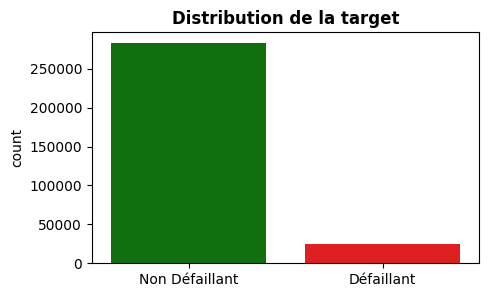

In [ ]:
# Distribution de la target
plt.figure(figsize=(5,3))
sns.countplot(x = 'TARGET', data = df, palette=['green', 'red'])
plt.title('Distribution de la target', fontweight='bold', fontsize = 12)
x = [0, 1]
plt.xticks(x, ['Non Défaillant', 'Défaillant'])
plt.xlabel('');

In [ ]:
Counter(df['TARGET'])

Counter({0: 282680, 1: 24825})

## Pipeline, optimisation et entrainement des modèles <a class="anchor" id="pipe"></a>

Nous allons dans un premier temps créer une **pipeline** pour chacun de nos modèles. Cette pipeline va nous permettre d'affecter des étapes de preprocessing à nos données, c'est à dire des transformations comme le traitement des données déséquilibrées, la standardisation de nos données, et de choisir le type de modèle.

Cette pipeline sera ensuite intégrée dans une fonction d'optimisation et d'entrainement qui va utiliser la **validation croisée** pour tester la robustesse du modèle prédictif en répétant la procédure de split. Elle donnera plusieurs erreurs d'apprentissage et de test et donc une **estimation de la variabilité de la performance de généralisation du modèle**. Ici, nous avons utilisé la méthode **KFold** qui consiste à découper le train set en cinq parties, l'entrainer sur les quatre premières parties puis le valider sur la cinquième. On recommencera sur toutes les configurations possibles puis on fera la moyenne des cinq scores et on pourra donc comparer nos modèles pour être sûr de prendre celui qui a en moyenne la meilleure performance.

Le réglage des hyperparamètres s'effectuera soit à l'aide du  **GridSearchCV** qui va tester toutes les combinaisons possibles d'hyperparamètres afin de trouver celles qui vont minimiser le plus l'erreur (méthode exhaustive très **coûteuse en termes de puissance de calcul et de temps**), soit du **RandomizedSearchCV** qui va sélectionner des combinaisaons aléatoires d'hyperparamètres. Cette méthode est un peu **moins précise** mais beaucoup **plus rapide**. Elle sera utilisée pour les modèles plus complexes.

Enfin, pour évaluer la **performance réelle de nos modèles**, nous calculerons les metriques sélectionnées sur les données de test.

La validation croisée peut être utilisée à la fois pour le **réglage des hyperparamètres** et pour l'estimation de la **performance de généralisation** d'un modèle. Cependant, l'utiliser à ces deux fins en même temps est problématique. Le réglage des hyperparamètres est une forme d'apprentissage automatique et, par conséquent, nous avons besoin d'une **autre boucle externe de validation croisée** pour évaluer correctement la performance de généralisation de la procédure de modélisation complète. Lorsque l'on optimise certaines parties de la pipeline d'apprentissage automatique (par exemple, les hyperparamètres, la transformation, etc.), il est nécessaire d'utiliser la **nested cross validation** pour évaluer la performance de généralisation du modèle prédictif. Sinon, les résultats obtenus sans nested cross validation sont souvent trop optimistes.  C’est ce qui a été fait pour visualiser la distribution de la métrique sélectionnée sur les données d’entrainement et de validation.

## Choix des scores <a class="anchor" id="scores"></a>

Si l'on se réfère au fichier de description des colonnes:
- **1** => clients a des difficultés de paiement, il a eu un retard de paiement de plus de X jours sur au moins une des Y premières échéances du prêt dans notre échantillon (**défaillant**)
- **0** => tous les autres cas (**non défaillant**)

Sur une matrice de confusion, les défaillants représentent la classe positive (Y=1) et les non défaillants la classe négative (Y=0).

Comme il serait extrêment coûteux pour la banque d'accorder un crédit à un client défaillant qui ne le rembourserait pas ou en partie, il nous faut **minimiser le nombre de faux négatifs** c'est à dire un client prédit non défaillant alors qu'il est défaillant.

Il faut également tâcher de **minimiser les faux positifs** c'est à dire prédire qu'un client est défaillant alors qu'il ne l'est pas (risque de perte de clients, de manque à gagner).

Cependant, un faux positif n'a pas le même coût qu'un faux négatif. Ce dernier est beaucoup plus coûteux pour la banque. **Nous accorderons donc 10 fois plus de poids aux faux négatifs** (fonction coût métier). 

Le **Rappel (Recall)** qui mesure le taux de vrais positifs est à favoriser au détriment de la précision qui est la capacité du classificateur à ne pas étiqueter comme positif un échantillon qui est négatif.

Pour faire cela, nous allons nous baser sur le **F-beta score** qui est la moyenne harmonique pondérée de la précision et du rappel. Le paramètre bêta détermine le poids du rappel dans le score. Lorsqu'il est suppérieur à un, il favorise le rappel. Nous testerons plusieurs valeurs pour le beta et garderons celui qui donne le meilleur score.

Nous mettrons également l'**accuracy** et l'**AUC** comme éléments de comparaison. Le **temps d'entrainement** sera également tracké.

Le choix du meilleur modèle se fera via **cross validation sur le betascore** puis sur les données de test en fonction du **score métier et du betascore**.

## Modélisations <a class="anchor" id="model"></a>

Nous cherchons à classer les demandes en **crédit accordé ou refusé**. Il s'agit donc d'un modèle de **classification binaire**.

### Modèle Baseline: Dummy classifier <a class="anchor" id="dummy"></a>

Ce classificateur fait des prédictions en utilisant des règles simples. Il est utile comme **base de référence simple** à comparer avec d'autres classificateurs et ne sera pas optimisé. Il ignore les variables en entrée et par conséquent, n'utilise aucune information provenant des features. Il n'y a donc **pas besoin de transformer au préalable nos features**.

In [ ]:
# Dummy classifier baseline model
# On renomme l'instance pour cohérence: dummy_clf
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

print("=" * 70)
print("DUMMY CLASSIFIER BASELINE")
print("=" * 70)

# Evaluate metrics
score_biz, betascore, recall, precision, accuracy, auc, y_pred = eval_metrics(dummy_clf, X_test, y_test, beta_value=2)



DUMMY CLASSIFIER BASELINE
Score métier: 50010
Beta score: 0.0
Recall: 0.0
Precision: 0.0
Accuracy: 0.9186842490366011
AUC: 0.5


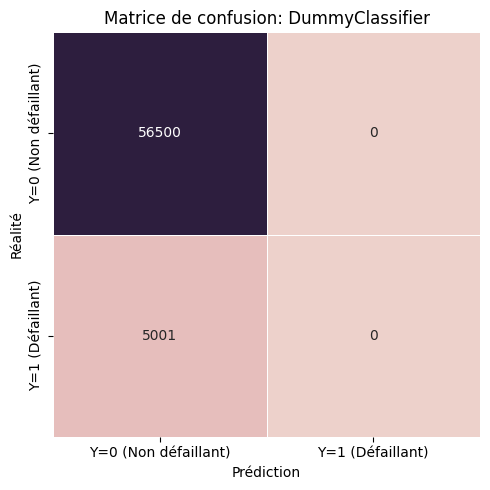

In [ ]:
# Plot de la matrice de confusion avec la fonction définie plus haut
plot_confusion_matrix(y_test, y_pred_dummy, model_name="DummyClassifier")


### Modèle Baseline: Regression Logistic <a class="anchor" id="dummy"></a>

La **régression logistique** est un modèle de classification binaire qui estime la probabilité qu'une observation appartienne à une classe en utilisant la fonction logistique (sigmoïde). 

**Avantages:**
- Simple, interprétable et rapide à entraîner
- Probabilités calibrées
- Performances solides sur données linéairement séparables

**Stratégie:**
Nous allons tester **toutes les stratégies de rééquilibrage** disponibles pour identifier celle qui offre les meilleures performances:
1. **Sans rééquilibrage** (baseline)
2. **Class weight balanced** (pondération des classes)
3. **SMOTE 0.5** (suréchantillonnage synthétique avec ratio 0.5)
4. **SMOTE 0.7** (suréchantillonnage synthétique avec ratio 0.7)
5. **Undersample 0.5** (sous-échantillonnage aléatoire avec ratio 0.5)
6. **Combine** (undersample + SMOTE combiné)

Pour chaque stratégie, nous optimiserons les hyperparamètres avec RandomizedSearchCV.

#### Configuration et préparation

In [ ]:
# Configuration flexible du GridSearch - À AJUSTER selon vos besoins
GRIDSEARCH_CONFIG = {
    'cv_splits': 2,           # Réduit à 2 pour rapidité
    'cv_repeats': 1,          # 1 repeat
    'use_randomized': True,   # Utiliser RandomizedSearchCV au lieu de GridSearchCV
    'n_iter': 1,              # UNE SEULE itération (grille déjà simplifiée)
    'verbose': 1              # 0=silencieux, 1=peu de texte, 2=détaillé
}

# Définition des stratégies de rééquilibrage à tester (réduites à essentielles)
balancing_strategies = {
    'none': {'strategy': 'none', 'sampling_ratio': None},
    'class_weight': {'strategy': 'class_weight', 'sampling_ratio': None},
    'smote_0.5': {'strategy': 'smote', 'sampling_ratio': 0.5},
    'smote_0.7': {'strategy': 'smote', 'sampling_ratio': 0.7},
    'undersample_0.5': {'strategy': 'undersample', 'sampling_ratio': 0.5},
    'combine': {'strategy': 'combine', 'sampling_ratio': 0.3}
}

# Grille d'hyperparamètres pour la régression logistique (OPTIMISÉE)
param_grid_lr = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs'],
    'classifier__max_iter': [100]
}

# Grille d'hyperparamètres pour LightGBM
param_grid_lgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [31, 50],
    'classifier__max_depth': [-1, 10, 15]
}

# Scorer personnalisé pour le F2-score
f2_scorer = make_scorer(fbeta_score, beta=2
                    )


#### Test de toutes les stratégies de rééquilibrage

In [ ]:
# Fonction helper pour utiliser GridSearch ou RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV

def create_search_cv(pipeline, param_grid, cv, scoring, config):
    """
    Crée GridSearchCV ou RandomizedSearchCV selon la configuration
    """
    if config['use_randomized']:
        return RandomizedSearchCV(
            pipeline,
            param_grid,
            n_iter=config['n_iter'],
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            verbose=config['verbose'],
            random_state=42
        )
    else:
        return GridSearchCV(
            pipeline,
            param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            verbose=config['verbose']
        )

print("✅ Fonction create_search_cv initialisée")

✅ Fonction create_search_cv initialisée


In [ ]:
# Définition de la fonction create_balanced_pipeline
# IMPORTANT: Utilise imblearn.pipeline.Pipeline SEULEMENT avec rééquilibrage
def create_balanced_pipeline(classifier, strategy='none', sampling_ratio=None, scaler=None):
    """
    Crée un pipeline avec rééquilibrage des données et classification
    
    Parameters:
    -----------
    classifier : estimator
        Le classificateur à utiliser (LogisticRegression, LGBMClassifier, etc.)
    strategy : str
        Stratégie de rééquilibrage: 'none', 'smote', 'smote_auto', 'undersample', 'combine'
    sampling_ratio : float
        Ratio de suréchantillonnage pour SMOTE (0 à 1)
    scaler : transformer
        Scaler pour normaliser les données (StandardScaler, etc.)
    
    Returns:
    --------
    Pipeline sklearn ou imblearn selon la stratégie
    """
    
    steps = []
    has_sampling = False  # Flag pour déterminer quel pipeline utiliser
    
    # Ajouter le scaler si fourni
    if scaler is not None:
        steps.append(('scaler', scaler))
    
    # Ajouter le rééquilibrage selon la stratégie
    if strategy == 'none':
        # Pas de rééquilibrage
        pass
    
    elif strategy == 'smote':
        # SMOTE avec ratio spécifié
        smote = SMOTE(sampling_strategy=sampling_ratio, random_state=42, n_jobs=-1)
        steps.append(('smote', smote))
        has_sampling = True
    
    elif strategy == 'smote_auto':
        # SMOTE auto (équilibre complet 1:1)
        smote = SMOTE(sampling_strategy='auto', random_state=42, n_jobs=-1)
        steps.append(('smote', smote))
        has_sampling = True
    
    elif strategy == 'undersample':
        # Sous-échantillonnage aléatoire
        rus = RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=42)
        steps.append(('undersample', rus))
        has_sampling = True
    
    elif strategy == 'combine':
        # Combinaison: sous-échantillonnage + SMOTE
        under = RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=42)
        over = SMOTE(sampling_strategy=0.5, random_state=42, n_jobs=-1)
        steps.append(('undersample', under))
        steps.append(('smote', over))
        has_sampling = True
    
    # Ajouter le classifier
    steps.append(('classifier', classifier))
    
    # Retourner le pipeline approprié
    if has_sampling:
        # Utiliser imblearn.pipeline seulement si rééquilibrage
        return pipe(steps)
    else:
        # Pas de rééquilibrage - utiliser sklearn.Pipeline standard
        return Pipeline(steps)

# Fonction spécifique pour LightGBM - gère mieux le rééquilibrage
def create_lgbm_pipeline(classifier, strategy='smote', sampling_ratio=None):
    """
    Crée un pipeline pour LightGBM avec rééquilibrage approprié
    LightGBM n'a pas besoin de scaler (tree-based)
    
    Parameters:
    -----------
    classifier : LGBMClassifier
        Le classificateur LightGBM
    strategy : str
        Stratégie de rééquilibrage: 'class_weight', 'smote', 'undersample', 'combine'
    sampling_ratio : float
        Ratio de suréchantillonnage
    
    Returns:
    --------
    Pipeline imblearn ou sklearn selon la stratégie
    """
    
    # Pour class_weight, utiliser sklearn.Pipeline simple
    # (le class_weight est géré par le classifier lui-même)
    if strategy == 'class_weight':
        return Pipeline([('classifier', classifier)])
    
    # Pour les autres stratégies, utiliser imblearn.pipeline avec rééquilibrage
    steps = []
    
    if strategy == 'smote':
        smote = SMOTE(sampling_strategy=sampling_ratio, random_state=42, n_jobs=-1)
        steps.append(('smote', smote))
    
    elif strategy == 'undersample':
        rus = RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=42)
        steps.append(('undersample', rus))
    
    elif strategy == 'combine':
        under = RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=42)
        over = SMOTE(sampling_strategy=0.5, random_state=42, n_jobs=-1)
        steps.append(('undersample', under))
        steps.append(('smote', over))
    
    # Ajouter le classifier
    steps.append(('classifier', classifier))
    
    # Retourner imblearn pipeline pour les stratégies avec rééquilibrage
    return pipe(steps)

print("✅ Fonction create_balanced_pipeline définie (Pipeline sklearn pour 'none', imblearn pour autres stratégies)")
print("✅ Fonction create_lgbm_pipeline définie (Pipeline optimisé pour LightGBM)")


✅ Fonction create_balanced_pipeline définie (Pipeline sklearn pour 'none', imblearn pour autres stratégies)
✅ Fonction create_lgbm_pipeline définie (Pipeline optimisé pour LightGBM)


In [ ]:
# Initialisation du dictionnaire pour stocker les résultats
results_lr = {}



2025/11/18 20:32:13 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



✅ MLFlow initialisé - Expérimentation: credit-scoring-projet7
📁 Tracking URI: ../mlruns

TESTING ALL BALANCING STRATEGIES - LOGISTIC REGRESSION

──────────────────────────────────────────────────────────────────────
📊 Testing: none
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LogisticRegression_none

 GridSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



 Results:
├─ Training time: 17.64s
├─ Best CV F2-Score: 0.0198
├─ Test F2-Score: 0.0176
├─ Test Recall: 0.0142
├─ Test Precision: 0.4931
├─ Test Accuracy: 0.9187
├─ Test AUC: 0.5065
└─ Score Métier: 49373
📝 Paramètres enregistrés: ['strategy', 'sampling_ratio', 'scaler', 'training_time', 'classifier__solver', 'classifier__penalty', 'classifier__max_iter', 'classifier__C']
📊 Métriques enregistrées: ['best_cv_f2_score', 'test_f2_score', 'test_recall', 'test_precision', 'test_accuracy', 'test_auc', 'score_metier']
💾 Modèle enregistré: lr_none


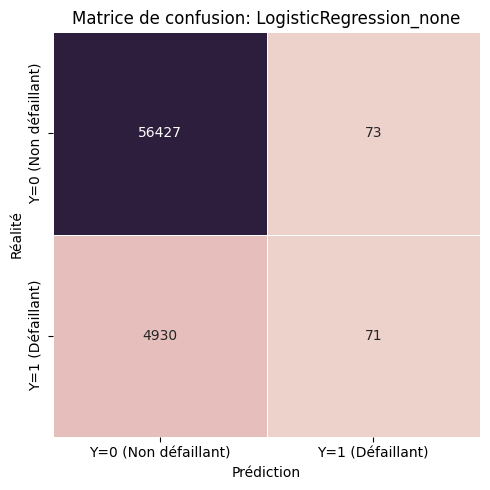

✅ Run terminée

──────────────────────────────────────────────────────────────────────
📊 Testing: class_weight
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LogisticRegression_class_weight

 GridSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



 Results:
├─ Training time: 16.83s
├─ Best CV F2-Score: 0.4110
├─ Test F2-Score: 0.4119
├─ Test Recall: 0.6723
├─ Test Precision: 0.1616
├─ Test Accuracy: 0.6896
├─ Test AUC: 0.6817
└─ Score Métier: 33838
📝 Paramètres enregistrés: ['strategy', 'sampling_ratio', 'scaler', 'training_time', 'classifier__solver', 'classifier__penalty', 'classifier__max_iter', 'classifier__C']
📊 Métriques enregistrées: ['best_cv_f2_score', 'test_f2_score', 'test_recall', 'test_precision', 'test_accuracy', 'test_auc', 'score_metier']
💾 Modèle enregistré: lr_class_weight


Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


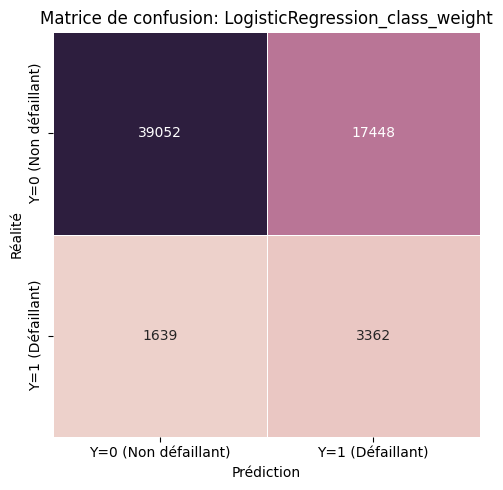

✅ Run terminée

──────────────────────────────────────────────────────────────────────
📊 Testing: smote_0.5
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LogisticRegression_smote_0.5

 GridSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\ashash\7\projet7-scoring-credit\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\AyaCheikh\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\AyaCheikh\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\AyaCheikh\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(exe


 Results:
├─ Training time: 26.93s
├─ Best CV F2-Score: 0.3463
├─ Test F2-Score: 0.3512
├─ Test Recall: 0.4087
├─ Test Precision: 0.2247
├─ Test Accuracy: 0.8373
├─ Test AUC: 0.6420
└─ Score Métier: 36622
📝 Paramètres enregistrés: ['strategy', 'sampling_ratio', 'scaler', 'training_time', 'classifier__solver', 'classifier__penalty', 'classifier__max_iter', 'classifier__C']
📊 Métriques enregistrées: ['best_cv_f2_score', 'test_f2_score', 'test_recall', 'test_precision', 'test_accuracy', 'test_auc', 'score_metier']
💾 Modèle enregistré: lr_smote_0.5


Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


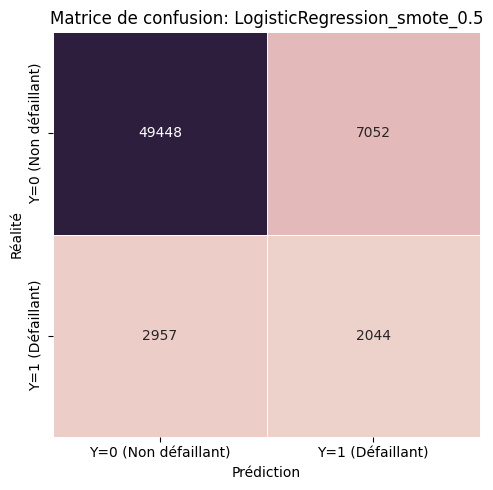

✅ Run terminée

──────────────────────────────────────────────────────────────────────
📊 Testing: smote_0.7
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LogisticRegression_smote_0.7

 GridSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



 Results:
├─ Training time: 29.93s
├─ Best CV F2-Score: 0.3850
├─ Test F2-Score: 0.3836
├─ Test Recall: 0.5189
├─ Test Precision: 0.1878
├─ Test Accuracy: 0.7784
├─ Test AUC: 0.6601
└─ Score Métier: 35282
📝 Paramètres enregistrés: ['strategy', 'sampling_ratio', 'scaler', 'training_time', 'classifier__solver', 'classifier__penalty', 'classifier__max_iter', 'classifier__C']
📊 Métriques enregistrées: ['best_cv_f2_score', 'test_f2_score', 'test_recall', 'test_precision', 'test_accuracy', 'test_auc', 'score_metier']
💾 Modèle enregistré: lr_smote_0.7


Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


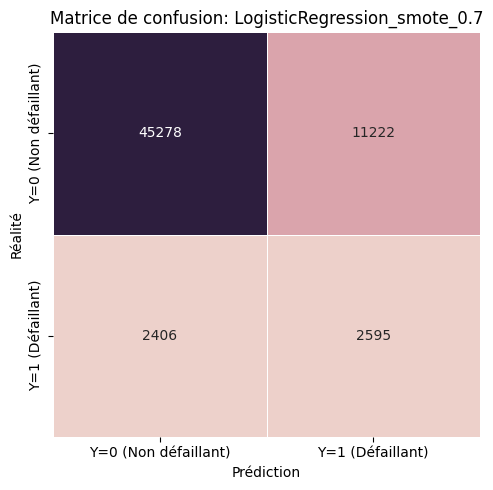

✅ Run terminée

──────────────────────────────────────────────────────────────────────
📊 Testing: undersample_0.5
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LogisticRegression_undersample_0.5

 GridSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



 Results:
├─ Training time: 8.39s
├─ Best CV F2-Score: 0.3482
├─ Test F2-Score: 0.3461
├─ Test Recall: 0.3939
├─ Test Precision: 0.2329
├─ Test Accuracy: 0.8452
├─ Test AUC: 0.6396
└─ Score Métier: 36797
📝 Paramètres enregistrés: ['strategy', 'sampling_ratio', 'scaler', 'training_time', 'classifier__solver', 'classifier__penalty', 'classifier__max_iter', 'classifier__C']
📊 Métriques enregistrées: ['best_cv_f2_score', 'test_f2_score', 'test_recall', 'test_precision', 'test_accuracy', 'test_auc', 'score_metier']
💾 Modèle enregistré: lr_undersample_0.5


Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


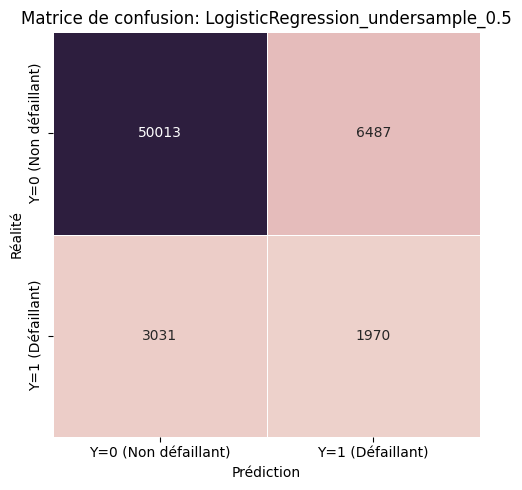

✅ Run terminée

──────────────────────────────────────────────────────────────────────
📊 Testing: combine
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LogisticRegression_combine

 GridSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



 Results:
├─ Training time: 14.97s
├─ Best CV F2-Score: 0.3511
├─ Test F2-Score: 0.3518
├─ Test Recall: 0.4043
├─ Test Precision: 0.2316
├─ Test Accuracy: 0.8425
├─ Test AUC: 0.6428
└─ Score Métier: 36498
📝 Paramètres enregistrés: ['strategy', 'sampling_ratio', 'scaler', 'training_time', 'classifier__solver', 'classifier__penalty', 'classifier__max_iter', 'classifier__C']
📊 Métriques enregistrées: ['best_cv_f2_score', 'test_f2_score', 'test_recall', 'test_precision', 'test_accuracy', 'test_auc', 'score_metier']
💾 Modèle enregistré: lr_combine


Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


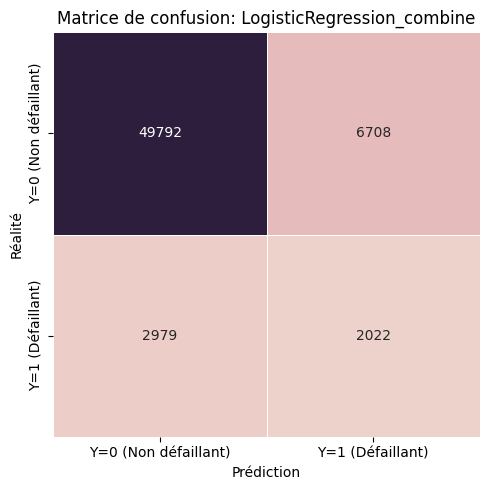

✅ Run terminée

✅ ALL LOGISTIC REGRESSION RUNS COMPLETED


In [ ]:
# Initialisation MLFlow
import sys
sys.path.append('..')

from src.mlflow_tracking.tracker import MLFlowTracker

# Initialiser le tracker MLFlow
tracker = MLFlowTracker(experiment_name="credit-scoring-projet7", tracking_uri="../mlruns")

print("\n" + "="*70)
print("TESTING ALL BALANCING STRATEGIES - LOGISTIC REGRESSION")
print("="*70)

# Boucle sur toutes les stratégies
for strategy_name, strategy_config in balancing_strategies.items():
    print(f"\n{'─'*70}")
    print(f"📊 Testing: {strategy_name}")
    print(f"{'─'*70}")
    
    # Démarrer une run MLFlow
    run_name = f"LogisticRegression_{strategy_name}"
    tracker.start_run(run_name=run_name)
    
    try:
        # Créer le modèle de base
        if strategy_config['strategy'] == 'class_weight':
            lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
            pipeline = create_balanced_pipeline(lr, 'none', scaler=StandardScaler())
        else:
            lr = LogisticRegression(random_state=42, max_iter=1000)
            pipeline = create_balanced_pipeline(
                lr, 
                strategy_config['strategy'], 
                sampling_ratio=strategy_config['sampling_ratio'],
                scaler=StandardScaler()
            )
        
        # Configurer la validation croisée stratifiée (optimisée)
        cv = RepeatedStratifiedKFold(
            n_splits=GRIDSEARCH_CONFIG['cv_splits'], 
            n_repeats=GRIDSEARCH_CONFIG['cv_repeats'], 
            random_state=42
        )
        
        # GridSearchCV ou RandomizedSearchCV selon la configuration
        grid_search = create_search_cv(
            pipeline,
            param_grid_lr,
            cv=cv,
            scoring=f2_scorer,
            config=GRIDSEARCH_CONFIG
        )
        
        # Entraînement
        print(f"\n GridSearchCV...")
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Meilleur modèle
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_cv_score = grid_search.best_score_
        
        # Prédictions sur le test set
        y_pred_test = best_model.predict(X_test)
        
        # Calcul des métriques
        score_biz = score_metier(y_test, y_pred_test)
        betascore = fbeta_score(y_test, y_pred_test, beta=2)
        recall = recall_score(y_test, y_pred_test)
        precision = precision_score(y_test, y_pred_test, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred_test)
        auc = roc_auc_score(y_test, y_pred_test)
        
        # Affichage des résultats
        print(f"\n Results:")
        print(f"├─ Training time: {training_time:.2f}s")
        print(f"├─ Best CV F2-Score: {best_cv_score:.4f}")
        print(f"├─ Test F2-Score: {betascore:.4f}")
        print(f"├─ Test Recall: {recall:.4f}")
        print(f"├─ Test Precision: {precision:.4f}")
        print(f"├─ Test Accuracy: {accuracy:.4f}")
        print(f"├─ Test AUC: {auc:.4f}")
        print(f"└─ Score Métier: {score_biz}")
        
        # Log des paramètres et hyperparamètres dans MLFlow
        params_to_log = {
            'strategy': strategy_config['strategy'],
            'sampling_ratio': strategy_config['sampling_ratio'] if strategy_config['sampling_ratio'] else 'N/A',
            'scaler': 'StandardScaler',
            'training_time': training_time,
            **best_params
        }
        tracker.log_params(params_to_log)
        
        # Log des métriques dans MLFlow
        metrics_to_log = {
            'best_cv_f2_score': best_cv_score,
            'test_f2_score': betascore,
            'test_recall': recall,
            'test_precision': precision,
            'test_accuracy': accuracy,
            'test_auc': auc,
            'score_metier': score_biz
        }
        tracker.log_metrics(metrics_to_log)
        
        # Log du modèle dans MLFlow
        tracker.log_model(best_model, model_name=f"lr_{strategy_name}")
        
        # Stocker les résultats
        results_lr[strategy_name] = {
            'model': best_model,
            'best_params': best_params,
            'best_cv_score': best_cv_score,
            'test_metrics': {
                'f2_score': betascore,
                'recall': recall,
                'precision': precision,
                'accuracy': accuracy,
                'auc': auc,
                'score_metier': score_biz
            },
            'y_pred': y_pred_test,
            'training_time': training_time,
            'run_id': mlflow.active_run().info.run_id
        }
        
        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred_test, model_name=f"LogisticRegression_{strategy_name}")
        
        # Terminer la run
        tracker.end_run()
        
    except Exception as e:
        print(f"❌ Erreur avec stratégie {strategy_name}: {str(e)}")
        tracker.end_run()
        continue

print("\n" + "="*70)
print("✅ ALL LOGISTIC REGRESSION RUNS COMPLETED")

print("="*70)

#### Comparaison des résultats

### LightGBM <a class="anchor" id="lightgbm"></a>
LightGBM est un gradient boosting basé sur des arbres de décision optimisé pour la vitesse et la performance (histogram-based, leaf-wise growth). 

Objectif: Réaliser le même processus que pour la régression logistique avec:
- Toutes les stratégies de rééquilibrage (`none`, `class_weight`, `smote_*`, `smote_auto`, `undersample`, `combine`)
- Optimisation des hyperparamètres principaux du modèle
- Tracking MLflow complet (paramètres, métriques, seuils, modèle)
- Sélection comparative finale.

Spécificités LightGBM pour données déséquilibrées:
- `class_weight` ou `is_unbalance=True` / `scale_pos_weight` (on utilisera `class_weight` pour cohérence)
- Risque d'overfitting avec trop de feuilles → contrôler `num_leaves` et `max_depth`
- Régularisation via `reg_alpha` / `reg_lambda`

On optimise le F2-score (Recall prioritaire) et on suit aussi le score métier (10*FN + FP).

In [ ]:
print("\n" + "="*70)
print("LIGHTGBM - CONFIGURATION")
print("="*70)

# Grille d'hyperparamètres pour LightGBM - ULTRA-SIMPLIFIÉE pour rapidité
param_grid_lgbm = {
    'classifier__num_leaves': [31],
    'classifier__max_depth': [7],
    'classifier__learning_rate': [0.05],
    'classifier__n_estimators': [100],
    'classifier__reg_alpha': [0.0],
    'classifier__reg_lambda': [0.0]
}

# Dictionnaire pour stocker les résultats
results_lgbm = {}

print("Configuration LightGBM terminée!")
print(f"Nombre de stratégies à tester: {len(balancing_strategies)}")
print(f"Hyperparamètres à optimiser: {list(param_grid_lgbm.keys())}")



LIGHTGBM - CONFIGURATION
Configuration LightGBM terminée!
Nombre de stratégies à tester: 6
Hyperparamètres à optimiser: ['classifier__num_leaves', 'classifier__max_depth', 'classifier__learning_rate', 'classifier__n_estimators', 'classifier__reg_alpha', 'classifier__reg_lambda']


In [ ]:
        # RandomizedSearchCV pour optimisation (moins coûteux que GridSearchCV)
        random_search = RandomizedSearchCV(
            pipeline,
            param_grid_lgbm,
            n_iter=GRIDSEARCH_CONFIG['n_iter'],  # Utiliser la config
            cv=cv,
            scoring=f2_scorer,
            n_jobs=1,  # IMPORTANT: Utiliser n_jobs=1 pour éviter les problèmes de pickling
            verbose=GRIDSEARCH_CONFIG['verbose'],
            random_state=42
        )

In [ ]:
# ============================================================================
# SCRIPT DE NETTOYAGE MLFLOW - À EXÉCUTER EN PREMIER
# ============================================================================

import mlflow

print("\n" + "="*70)
print("🧹 NETTOYAGE DES RUNS MLFLOW ACTIVES")
print("="*70)

# Terminer toutes les runs actives
run_ended = False
max_attempts = 5

for i in range(max_attempts):
    try:
        active_run = mlflow.active_run()
        if active_run:
            print(f"⚠️ Run active détectée: {active_run.info.run_id}")
            mlflow.end_run()
            print(f"✅ Run {active_run.info.run_id} terminée")
            run_ended = True
        else:
            break
    except Exception as e:
        print(f"ℹ️ Tentative {i+1}/{max_attempts}: {str(e)}")
        break

if run_ended:
    print("\n✅ Toutes les runs actives ont été terminées")
else:
    print("\n✅ Aucune run active détectée")

# Vérification finale
try:
    active_run = mlflow.active_run()
    if active_run:
        print(f"\n⚠️ ATTENTION: Une run est encore active: {active_run.info.run_id}")
        print("Exécutez: mlflow.end_run()")
    else:
        print("\n✅ Prêt pour démarrer l'entraînement LightGBM")
except:
    print("\n✅ Prêt pour démarrer l'entraînement LightGBM")

print("="*70 + "\n")


🧹 NETTOYAGE DES RUNS MLFLOW ACTIVES

✅ Aucune run active détectée

✅ Prêt pour démarrer l'entraînement LightGBM




🧹 NETTOYAGE DES NOMS DE COLONNES
✅ 6 colonnes renommées pour compatibilité LightGBM
✅ 6 colonnes renommées pour compatibilité LightGBM
✅ X_train_clean: (246004, 299)
✅ X_test_clean: (61501, 299)
✅ MLFlow initialisé - Expérimentation: credit-scoring-projet7
📁 Tracking URI: ../mlruns

TESTING ALL BALANCING STRATEGIES - LIGHTGBM

──────────────────────────────────────────────────────────────────────
📊 Testing: none
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LightGBM_none

🔍 RandomizedSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits

📈 Results:
├─ Training time: 22.40s
├─ Best CV F2-Score: 0.0416
├─ Test F2-Score: 0.0416
├─ Test Recall: 0.0338
├─ Test Precision: 0.5417
├─ Test Accuracy: 0.9191
├─ Test AUC: 0.7616
└─ Score Métier: 48463
📝 Paramètres enregistrés: ['model_type', 'strategy', 'sampling_ratio', 'scaler', 'training_time', 'cv_splits', 'cv_repeats', 'classifier__num_leaves', 'classifier__n_estimators', 'cl

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


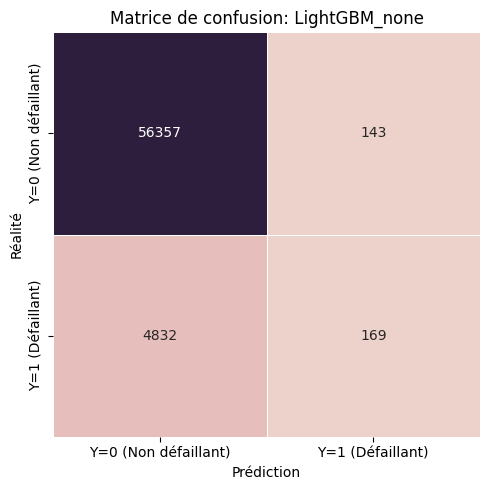

✅ Run terminée

──────────────────────────────────────────────────────────────────────
📊 Testing: class_weight
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LightGBM_class_weight

🔍 RandomizedSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits

📈 Results:
├─ Training time: 23.10s
├─ Best CV F2-Score: 0.4021
├─ Test F2-Score: 0.4202
├─ Test Recall: 0.6143
├─ Test Precision: 0.1856
├─ Test Accuracy: 0.7495
├─ Test AUC: 0.7584
└─ Score Métier: 32767
📝 Paramètres enregistrés: ['model_type', 'strategy', 'sampling_ratio', 'scaler', 'training_time', 'cv_splits', 'cv_repeats', 'classifier__num_leaves', 'classifier__n_estimators', 'classifier__max_depth', 'classifier__learning_rate']
📊 Métriques enregistrées: ['best_cv_f2_score', 'test_f2_score', 'test_recall', 'test_precision', 'test_accuracy', 'test_auc', 'score_metier']
💾 Modèle enregistré: lgbm_class_weight


Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


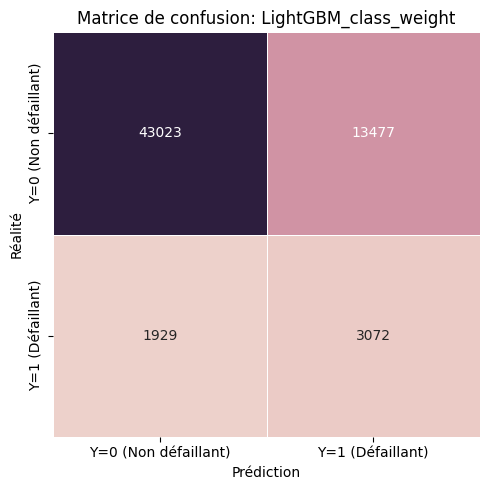

✅ Run terminée

──────────────────────────────────────────────────────────────────────
📊 Testing: smote_0.5
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LightGBM_smote_0.5

🔍 RandomizedSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits

📈 Results:
├─ Training time: 45.47s
├─ Best CV F2-Score: 0.0374
├─ Test F2-Score: 0.0370
├─ Test Recall: 0.0300
├─ Test Precision: 0.5357
├─ Test Accuracy: 0.9190
├─ Test AUC: 0.7596
└─ Score Métier: 48640
📝 Paramètres enregistrés: ['model_type', 'strategy', 'sampling_ratio', 'scaler', 'training_time', 'cv_splits', 'cv_repeats', 'classifier__num_leaves', 'classifier__n_estimators', 'classifier__max_depth', 'classifier__learning_rate']
📊 Métriques enregistrées: ['best_cv_f2_score', 'test_f2_score', 'test_recall', 'test_precision', 'test_accuracy', 'test_auc', 'score_metier']
💾 Modèle enregistré: lgbm_smote_0.5


Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


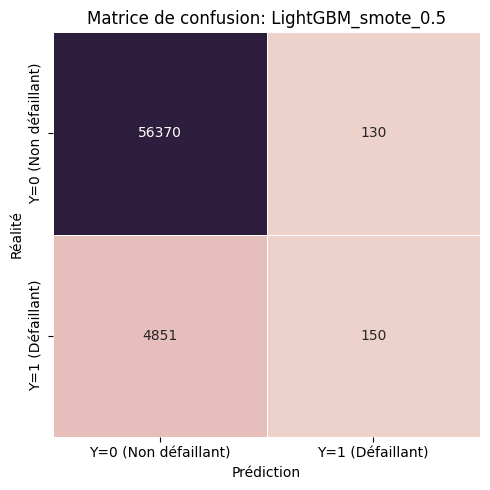

✅ Run terminée

──────────────────────────────────────────────────────────────────────
📊 Testing: smote_0.7
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LightGBM_smote_0.7

🔍 RandomizedSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits

📈 Results:
├─ Training time: 48.98s
├─ Best CV F2-Score: 0.0387
├─ Test F2-Score: 0.0353
├─ Test Recall: 0.0286
├─ Test Precision: 0.5219
├─ Test Accuracy: 0.9189
├─ Test AUC: 0.7607
└─ Score Métier: 48711
📝 Paramètres enregistrés: ['model_type', 'strategy', 'sampling_ratio', 'scaler', 'training_time', 'cv_splits', 'cv_repeats', 'classifier__num_leaves', 'classifier__n_estimators', 'classifier__max_depth', 'classifier__learning_rate']
📊 Métriques enregistrées: ['best_cv_f2_score', 'test_f2_score', 'test_recall', 'test_precision', 'test_accuracy', 'test_auc', 'score_metier']
💾 Modèle enregistré: lgbm_smote_0.7


Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


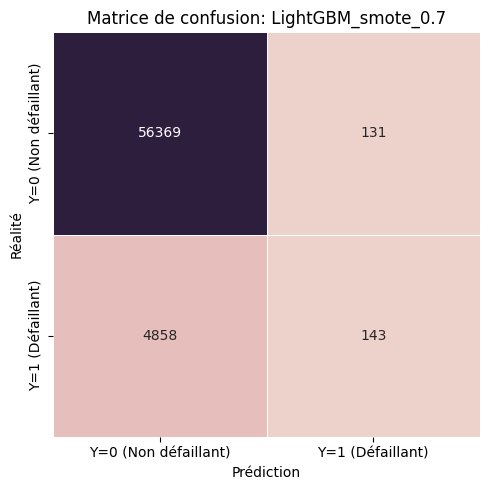

✅ Run terminée

──────────────────────────────────────────────────────────────────────
📊 Testing: undersample_0.5
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LightGBM_undersample_0.5

🔍 RandomizedSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits

📈 Results:
├─ Training time: 9.94s
├─ Best CV F2-Score: 0.3646
├─ Test F2-Score: 0.3724
├─ Test Recall: 0.4335
├─ Test Precision: 0.2380
├─ Test Accuracy: 0.8411
├─ Test AUC: 0.7589
└─ Score Métier: 35270
📝 Paramètres enregistrés: ['model_type', 'strategy', 'sampling_ratio', 'scaler', 'training_time', 'cv_splits', 'cv_repeats', 'classifier__num_leaves', 'classifier__n_estimators', 'classifier__max_depth', 'classifier__learning_rate']
📊 Métriques enregistrées: ['best_cv_f2_score', 'test_f2_score', 'test_recall', 'test_precision', 'test_accuracy', 'test_auc', 'score_metier']
💾 Modèle enregistré: lgbm_undersample_0.5


Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


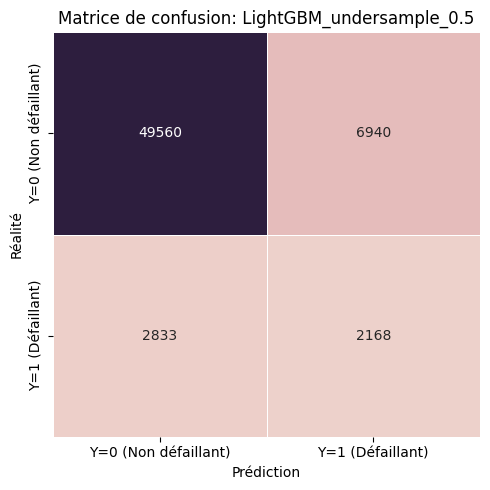

✅ Run terminée

──────────────────────────────────────────────────────────────────────
📊 Testing: combine
──────────────────────────────────────────────────────────────────────
🚀 Nouvelle run démarrée: LightGBM_combine

🔍 RandomizedSearchCV...
Fitting 2 folds for each of 1 candidates, totalling 2 fits

📈 Results:
├─ Training time: 21.53s
├─ Best CV F2-Score: 0.2639
├─ Test F2-Score: 0.2771
├─ Test Recall: 0.2693
├─ Test Precision: 0.3129
├─ Test Accuracy: 0.8925
├─ Test AUC: 0.7604
└─ Score Métier: 39498
📝 Paramètres enregistrés: ['model_type', 'strategy', 'sampling_ratio', 'scaler', 'training_time', 'cv_splits', 'cv_repeats', 'classifier__num_leaves', 'classifier__n_estimators', 'classifier__max_depth', 'classifier__learning_rate']
📊 Métriques enregistrées: ['best_cv_f2_score', 'test_f2_score', 'test_recall', 'test_precision', 'test_accuracy', 'test_auc', 'score_metier']
💾 Modèle enregistré: lgbm_combine


Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


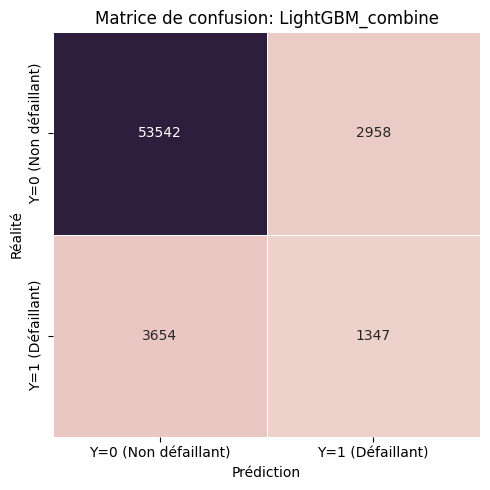

✅ Run terminée

✅ ALL LIGHTGBM RUNS COMPLETED

📊 SUMMARY - LIGHTGBM RESULTS

Strategy             F2-Score     Recall     Precision    AUC        Score Métier   
──────────────────────────────────────────────────────────────────────────────────────────
none                 0.0416       0.0338     0.5417       0.7616     48463          
class_weight         0.4202       0.6143     0.1856       0.7584     32767          
smote_0.5            0.0370       0.0300     0.5357       0.7596     48640          
smote_0.7            0.0353       0.0286     0.5219       0.7607     48711          
undersample_0.5      0.3724       0.4335     0.2380       0.7589     35270          
combine              0.2771       0.2693     0.3129       0.7604     39498          

──────────────────────────────────────────────────────────────────────────────────────────
🏆 Best Strategy: class_weight (F2-Score: 0.4202)

📈 Statistiques additionnelles:
├─ Nombre de stratégies testées: 6
├─ Temps total d'entraînement

In [ ]:
# ============================================================================
# SCRIPT COMPLET : LIGHTGBM AVEC NETTOYAGE DES COLONNES
# ============================================================================

import re
import sys
import time
import mlflow
sys.path.append('..')

from src.mlflow_tracking.tracker import MLFlowTracker

# ============================================================================
# ÉTAPE 1 : FONCTION DE NETTOYAGE DES NOMS DE COLONNES
# ============================================================================

def clean_column_names(df):
    """Nettoie les noms de colonnes pour LightGBM"""
    forbidden_chars = r'[\[\]{}:,"\']'
    column_mapping = {}
    
    for col in df.columns:
        new_col = re.sub(forbidden_chars, '_', str(col))
        new_col = re.sub(r'_+', '_', new_col)
        new_col = new_col.strip('_')
        column_mapping[col] = new_col
    
    df_clean = df.rename(columns=column_mapping)
    
    changes = [(old, new) for old, new in column_mapping.items() if old != new]
    if changes:
        print(f"✅ {len(changes)} colonnes renommées pour compatibilité LightGBM")
    
    return df_clean

# ============================================================================
# ÉTAPE 2 : NETTOYER LES DONNÉES
# ============================================================================

print("\n" + "="*70)
print("🧹 NETTOYAGE DES NOMS DE COLONNES")
print("="*70)

X_train_clean = clean_column_names(X_train)
X_test_clean = clean_column_names(X_test)

print(f"✅ X_train_clean: {X_train_clean.shape}")
print(f"✅ X_test_clean: {X_test_clean.shape}")

# ============================================================================
# ÉTAPE 3 : ENTRAÎNEMENT LIGHTGBM
# ============================================================================

# Initialiser le tracker MLFlow
tracker = MLFlowTracker(experiment_name="credit-scoring-projet7", tracking_uri="../mlruns")

# Dictionnaire pour stocker les résultats
results_lgbm = {}

print("\n" + "="*70)
print("TESTING ALL BALANCING STRATEGIES - LIGHTGBM")
print("="*70)

# Boucle sur toutes les stratégies
for strategy_name, strategy_config in balancing_strategies.items():
    print(f"\n{'─'*70}")
    print(f"📊 Testing: {strategy_name}")
    print(f"{'─'*70}")
    
    run_name = f"LightGBM_{strategy_name}"
    tracker.start_run(run_name=run_name)
    
    try:
        # Créer le modèle LightGBM
        if strategy_config['strategy'] == 'class_weight':
            lgbm = LGBMClassifier(
                class_weight='balanced',
                random_state=42,
                n_jobs=-1,
                verbose=-1
            )
            pipeline = create_lgbm_pipeline(lgbm, strategy='class_weight')
        else:
            lgbm = LGBMClassifier(
                random_state=42,
                n_jobs=-1,
                verbose=-1
            )
            pipeline = create_lgbm_pipeline(
                lgbm, 
                strategy=strategy_config['strategy'], 
                sampling_ratio=strategy_config['sampling_ratio']
            )
        
        # Validation croisée
        cv = RepeatedStratifiedKFold(
            n_splits=GRIDSEARCH_CONFIG['cv_splits'], 
            n_repeats=GRIDSEARCH_CONFIG['cv_repeats'], 
            random_state=42
        )
        
        # Recherche d'hyperparamètres
        grid_search = create_search_cv(
            pipeline,
            param_grid_lgb,
            cv=cv,
            scoring=f2_scorer,
            config=GRIDSEARCH_CONFIG
        )
        
        # Entraînement
        print(f"\n🔍 {'RandomizedSearchCV' if GRIDSEARCH_CONFIG['use_randomized'] else 'GridSearchCV'}...")
        start_time = time.time()
        grid_search.fit(X_train_clean, y_train)  # ← DONNÉES NETTOYÉES
        training_time = time.time() - start_time
        
        # Meilleur modèle
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_cv_score = grid_search.best_score_
        
        # Prédictions
        y_pred_test = best_model.predict(X_test_clean)  # ← DONNÉES NETTOYÉES
        y_pred_proba_test = best_model.predict_proba(X_test_clean)[:, 1]
        
        # Métriques
        score_biz = score_metier(y_test, y_pred_test)
        betascore = fbeta_score(y_test, y_pred_test, beta=2)
        recall = recall_score(y_test, y_pred_test)
        precision = precision_score(y_test, y_pred_test, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred_test)
        auc = roc_auc_score(y_test, y_pred_proba_test)
        
        # Affichage
        print(f"\n📈 Results:")
        print(f"├─ Training time: {training_time:.2f}s")
        print(f"├─ Best CV F2-Score: {best_cv_score:.4f}")
        print(f"├─ Test F2-Score: {betascore:.4f}")
        print(f"├─ Test Recall: {recall:.4f}")
        print(f"├─ Test Precision: {precision:.4f}")
        print(f"├─ Test Accuracy: {accuracy:.4f}")
        print(f"├─ Test AUC: {auc:.4f}")
        print(f"└─ Score Métier: {score_biz}")
        
        # MLflow logging
        params_to_log = {
            'model_type': 'LightGBM',
            'strategy': strategy_config['strategy'],
            'sampling_ratio': strategy_config['sampling_ratio'] if strategy_config['sampling_ratio'] else 'N/A',
            'scaler': 'None',
            'training_time': training_time,
            'cv_splits': GRIDSEARCH_CONFIG['cv_splits'],
            'cv_repeats': GRIDSEARCH_CONFIG['cv_repeats'],
            **best_params
        }
        tracker.log_params(params_to_log)
        
        metrics_to_log = {
            'best_cv_f2_score': best_cv_score,
            'test_f2_score': betascore,
            'test_recall': recall,
            'test_precision': precision,
            'test_accuracy': accuracy,
            'test_auc': auc,
            'score_metier': score_biz
        }
        tracker.log_metrics(metrics_to_log)
        
        tracker.log_model(best_model, model_name=f"lgbm_{strategy_name}")
        
        # Stocker résultats
        results_lgbm[strategy_name] = {
            'model': best_model,
            'best_params': best_params,
            'best_cv_score': best_cv_score,
            'test_metrics': {
                'f2_score': betascore,
                'recall': recall,
                'precision': precision,
                'accuracy': accuracy,
                'auc': auc,
                'score_metier': score_biz
            },
            'y_pred': y_pred_test,
            'y_pred_proba': y_pred_proba_test,
            'training_time': training_time,
            'run_id': mlflow.active_run().info.run_id
        }
        
        # Confusion matrix
        plot_confusion_matrix(y_test, y_pred_test, model_name=f"LightGBM_{strategy_name}")
        
        tracker.end_run()
        
    except Exception as e:
        print(f"❌ Erreur: {str(e)}")
        import traceback
        traceback.print_exc()
        tracker.end_run()
        continue

# ============================================================================
# ÉTAPE 4 : RÉSUMÉ DES RÉSULTATS
# ============================================================================

print("\n" + "="*70)
print("✅ ALL LIGHTGBM RUNS COMPLETED")
print("="*70)

print("\n" + "="*70)
print("📊 SUMMARY - LIGHTGBM RESULTS")
print("="*70)

if results_lgbm:
    print(f"\n{'Strategy':<20} {'F2-Score':<12} {'Recall':<10} {'Precision':<12} {'AUC':<10} {'Score Métier':<15}")
    print("─" * 90)
    
    for strategy_name, result in results_lgbm.items():
        metrics = result['test_metrics']
        print(f"{strategy_name:<20} {metrics['f2_score']:<12.4f} {metrics['recall']:<10.4f} "
              f"{metrics['precision']:<12.4f} {metrics['auc']:<10.4f} {metrics['score_metier']:<15}")
    
    best_strategy = max(results_lgbm.items(), key=lambda x: x[1]['test_metrics']['f2_score'])
    print("\n" + "─" * 90)
    print(f"🏆 Best Strategy: {best_strategy[0]} (F2-Score: {best_strategy[1]['test_metrics']['f2_score']:.4f})")
    
    # Statistiques additionnelles
    print("\n📈 Statistiques additionnelles:")
    print(f"├─ Nombre de stratégies testées: {len(results_lgbm)}")
    print(f"├─ Temps total d'entraînement: {sum(r['training_time'] for r in results_lgbm.values()):.2f}s")
    print(f"└─ Temps moyen par stratégie: {sum(r['training_time'] for r in results_lgbm.values())/len(results_lgbm):.2f}s")
else:
    print("\n⚠️ Aucun résultat disponible")

print("\n" + "="*70)

In [ ]:
# Fermer proprement toute run MLflow active
import mlflow
try:
    if mlflow.active_run():
        mlflow.end_run()
        print("✅ Run MLflow fermée proprement")
except Exception as e:
    print(f"Note: {e}")


## Sélection du meilleur modèle <a class="anchor" id="best"></a>



In [ ]:
all_results = []

# --- Logistic Regression ---
if 'results_lr' in globals() and results_lr:
    for strategy_name, result in results_lr.items():
        metrics = result['test_metrics']
        all_results.append({
            'Model': 'Logistic Regression',
            'Strategy': strategy_name,
            'F2-Score': metrics['f2_score'],
            'Recall': metrics['recall'],
            'Precision': metrics['precision'],
            'Accuracy': metrics['accuracy'],
            'AUC': metrics['auc'],
            'Score Métier': metrics['score_metier'],
            'CV F2-Score': result['best_cv_score'],
            'Training Time (s)': result['training_time']
        })

# --- LightGBM ---
if 'results_lgbm' in globals() and results_lgbm:
    for strategy_name, result in results_lgbm.items():
        metrics = result['test_metrics']
        all_results.append({
            'Model': 'LightGBM',
            'Strategy': strategy_name,
            'F2-Score': metrics['f2_score'],
            'Recall': metrics['recall'],
            'Precision': metrics['precision'],
            'Accuracy': metrics['accuracy'],
            'AUC': metrics['auc'],
            'Score Métier': metrics['score_metier'],
            'CV F2-Score': result['best_cv_score'],
            'Training Time (s)': result['training_time']
        })

df_models_recap = pd.DataFrame(all_results)

if len(df_models_recap) == 0:
    print("\n Aucun résultat trouvé.")
else:
    df_models_recap = df_models_recap.sort_values('F2-Score', ascending=False).reset_index(drop=True)
    df_models_recap.insert(0, 'Rank', range(1, len(df_models_recap) + 1))

    # =====================
    #     STYLE DATAFRAME
    # =====================

    styled_df = (
        df_models_recap.style
        .background_gradient(subset=['Score Métier'], cmap='RdYlGn')
        .background_gradient(subset=['F2-Score'], cmap='RdYlGn', vmin=0.4, vmax=0.8)
        .background_gradient(subset=['Recall'], cmap='YlOrRd', vmin=0.4, vmax=1.0)
        .background_gradient(subset=['Precision'], cmap='Blues', vmin=0.3, vmax=0.8)
        .background_gradient(subset=['AUC'], cmap='Purples', vmin=0.5, vmax=0.9)
        .highlight_max(subset=['F2-Score'], color='#90EE90')
        .highlight_max(subset=['Recall'], color='#FFD700')
        .highlight_max(subset=['AUC'], color='#87CEEB')
        .highlight_min(subset=['Score Métier'], color="#90EE90")
        .set_properties(**{
            'text-align': 'center',
            'font-size': '12px',
            'border': '1px solid #ddd',
            'padding': '8px'
        })
        .set_table_styles([
            {
                'selector': 'th',
                'props': [
                    ('background-color', '#2E86AB'),
                    ('color', 'white'),
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('padding', '12px'),
                    ('border', '1px solid white'),
                    ('font-size', '13px')
                ]
            },
            {
                'selector': 'tr:hover',
                'props': [
                    ('background-color', "#1fbb5b"),
                    ('cursor', 'pointer')
                ]
            }
        ])
        .format({
            'F2-Score': '{:.4f}',
            'Recall': '{:.4f}',
            'Precision': '{:.4f}',
            'Accuracy': '{:.4f}',
            'AUC': '{:.4f}',
            'CV F2-Score': '{:.4f}',
            'Score Métier': '{:,.0f}',
            'Training Time (s)': '{:.2f}'
        })
    )

    print("\n")
    display(styled_df)


,Rank,Model,Strategy,F2-Score,Recall,Precision,Accuracy,AUC,Score Métier,CV F2-Score,Training Time (s)
0,1,LightGBM,class_weight,0.4202,0.6143,0.1856,0.7495,0.7584,"32,767",0.4021,23.10
1,2,Logistic Regression,class_weight,0.4119,0.6723,0.1616,0.6896,0.6817,"33,838",0.4110,16.83
2,3,Logistic Regression,smote_0.7,0.3836,0.5189,0.1878,0.7784,0.6601,"35,282",0.3850,29.93
3,4,LightGBM,undersample_0.5,0.3724,0.4335,0.2380,0.8411,0.7589,"35,270",0.3646,9.94
4,5,Logistic Regression,combine,0.3518,0.4043,0.2316,0.8425,0.6428,"36,498",0.3511,14.97
5,6,Logistic Regression,smote_0.5,0.3512,0.4087,0.2247,0.8373,0.6420,"36,622",0.3463,26.93
6,7,Logistic Regression,undersample_0.5,0.3461,0.3939,0.2329,0.8452,0.6396,"36,797",0.3482,8.39
7,8,LightGBM,combine,0.2771,0.2693,0.3129,0.8925,0.7604,"39,498",0.2639,21.53
8,9,LightGBM,none,0.0416,0.0338,0.5417,0.9191,0.7616,"48,463",0.0416,22.40
9,10,LightGBM,smote_0.5,0.0370,0.0300,0.5357,0.9190,0.7596,"48,640",0.0374,45.47



📊 BARPLOT COMPARATIF: F2-SCORE vs SCORE MÉTIER




📊 BARPLOT COMPARATIF: F2-SCORE vs SCORE MÉTIER



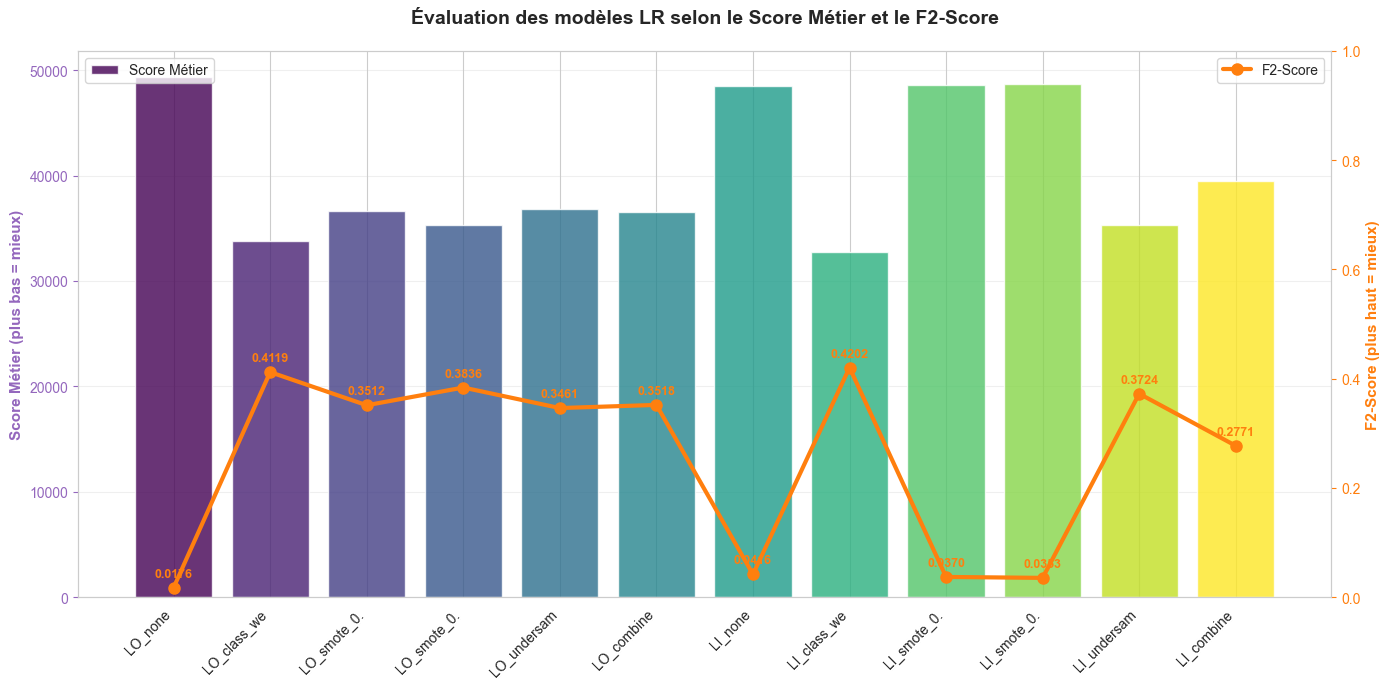

In [ ]:
# Création d'un barplot montrant la performance sur le fbeta_score et le score métier
print("\n" + "="*100)
print("📊 BARPLOT COMPARATIF: F2-SCORE vs SCORE MÉTIER")
print("="*100 + "\n")


plot_df = pd.DataFrame(all_results) 
plot_df['Modèle'] = plot_df['Model'].str[:2].str.upper() + "_" + plot_df['Strategy'].str[:8]

# Créer le plot avec les données correctes
fig, ax1 = plt.subplots(figsize=(14, 7))
sns.set_style("whitegrid")

# Créer une nouvelle figure avec positions x explicites pour éviter le conflit
x_pos = np.arange(len(plot_df))
bars = ax1.bar(x_pos, plot_df['Score Métier'].values, color=plt.cm.viridis(np.linspace(0, 1, len(plot_df))), alpha=0.8)

ax1.set_title("Évaluation des modèles LR selon le Score Métier et le F2-Score", 
              fontweight="bold", fontsize=14, pad=20)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(plot_df['Modèle'].values, rotation=45, ha='right', fontsize=10)
ax1.yaxis.label.set_color('tab:purple')
ax1.tick_params(axis='y', colors='tab:purple')
ax1.set_ylabel('Score Métier (plus bas = mieux)', fontsize=11, fontweight='bold', color='tab:purple')
ax1.grid(axis='y', alpha=0.3)

# Twin axis pour le F2-Score
ax2 = ax1.twinx()
line = ax2.plot(x_pos, plot_df['F2-Score'].values, marker='o', 
                color='tab:orange', linewidth=3, markersize=8, label='F2-Score')
ax2.set_ylim(0, 1)
ax2.yaxis.label.set_color('tab:orange')
ax2.tick_params(axis='y', colors='tab:orange')
ax2.set_ylabel('F2-Score (plus haut = mieux)', fontsize=11, fontweight='bold', color='tab:orange')
ax2.grid(None)

# Ajouter les valeurs sur les points
for i, val in enumerate(plot_df['F2-Score'].values):
    ax2.text(i, val + 0.02, f'{val:.4f}', ha='center', fontsize=9, fontweight='bold', color='tab:orange')

# Légende
ax1.legend(['Score Métier'], loc='upper left', fontsize=10)
ax2.legend(['F2-Score'], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()




🏆 MEILLEUR MODÈLE - RANK 1

📊 Meilleur Modèle:
  ├─ Modèle: LightGBM
  ├─ Stratégie: class_weight
  ├─ F2-Score: 0.4202
  ├─ Recall: 0.6143
  ├─ Precision: 0.1856
  ├─ Accuracy: 0.7495
  ├─ AUC: 0.7584
  ├─ Score Métier: 32767
  └─ Training Time: 23.10s

✅ Modèle sélectionné: LightGBM - class_weight

📊 FEATURE IMPORTANCE

🔝 TOP 20 FEATURES - Feature Importances (LightGBM):


                       Feature  Importance
                  EXT_SOURCE_2         307
               CREDIT_DURATION         223
POS_CNT_INSTALMENT_FUTURE_MEAN         215
                YEARS_EMPLOYED         214
BURO_YEARS_CREDIT_ENDDATE_MEAN         208
                  PAYMENT_RATE         208
              YEARS_ID_PUBLISH         193
     INSTAL_DAYS_PAST_DUE_MEAN         192
                           AGE         190
                   AMT_ANNUITY         178
                    DEBT_RATIO         172
             CREDIT_GOODS_PERC         170
      BURO_AMT_CREDIT_SUM_MEAN         167
   INSTAL_DAYS_BEFO

Glyph 127942 (\N{TROPHY}) missing from current font.
Glyph 127942 (\N{TROPHY}) missing from current font.


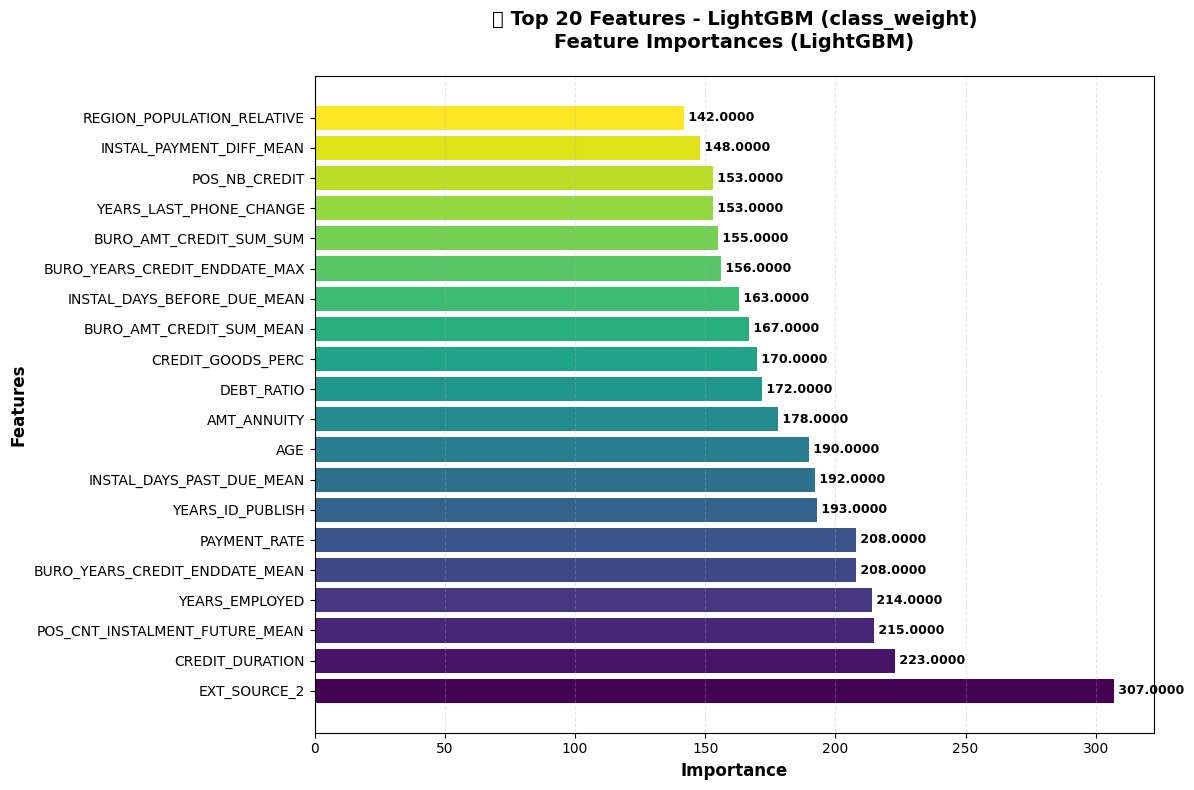

Glyph 127942 (\N{TROPHY}) missing from current font.


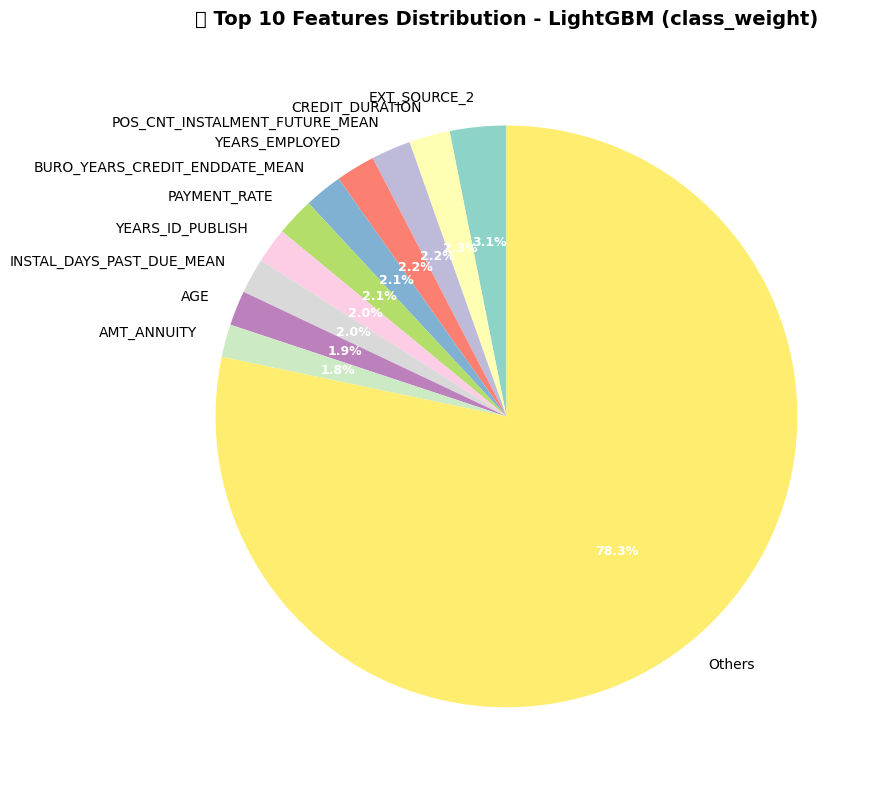


📈 STATISTIQUES D'IMPORTANCE

Total Features                 299
Importance Max                 307.0000
Importance Min                 0.0000
Importance Mean                32.7759
Importance Std                 50.9355

Cumulative Importance:        
  ├─ Top 5 features: 11.91%
  ├─ Top 10 features: 21.71%
  ├─ Top 20 features: 37.83%
  └─ All features: 100.00%



In [ ]:

# ============================================================================
# 🏆 EXTRACTION DU MEILLEUR MODÈLE (RANK 1) ET FEATURE IMPORTANCE
# ============================================================================

print("\n" + "="*100)
print("🏆 MEILLEUR MODÈLE - RANK 1")
print("="*100)

# Récupérer la ligne du meilleur modèle
best_model_row = df_models_recap.loc[0]

print(f"\n📊 Meilleur Modèle:")
print(f"  ├─ Modèle: {best_model_row['Model']}")
print(f"  ├─ Stratégie: {best_model_row['Strategy']}")
print(f"  ├─ F2-Score: {best_model_row['F2-Score']:.4f}")
print(f"  ├─ Recall: {best_model_row['Recall']:.4f}")
print(f"  ├─ Precision: {best_model_row['Precision']:.4f}")
print(f"  ├─ Accuracy: {best_model_row['Accuracy']:.4f}")
print(f"  ├─ AUC: {best_model_row['AUC']:.4f}")
print(f"  ├─ Score Métier: {best_model_row['Score Métier']:.0f}")
print(f"  └─ Training Time: {best_model_row['Training Time (s)']:.2f}s")

# Déterminer le meilleur modèle à partir des dictionnaires
model_type = best_model_row['Model']
strategy = best_model_row['Strategy']

if model_type == 'Logistic Regression':
    best_model_obj = results_lr[strategy]['model']
    print(f"\n✅ Modèle sélectionné: Logistic Regression - {strategy}")
else:
    best_model_obj = results_lgbm[strategy]['model']
    print(f"\n✅ Modèle sélectionné: LightGBM - {strategy}")

# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================

print("\n" + "="*100)
print("📊 FEATURE IMPORTANCE")
print("="*100)

# Vérifier le type de modèle et extraire les coefficients/importance
if hasattr(best_model_obj, 'named_steps'):
    # C'est une pipeline
    classifier = best_model_obj.named_steps.get('classifier')
else:
    classifier = best_model_obj

# Déterminer le type et extraire l'importance
if model_type == 'Logistic Regression':
    # Pour Logistic Regression, utiliser les coefficients
    if hasattr(classifier, 'coef_'):
        importance_values = np.abs(classifier.coef_[0])
        importance_type = "Coefficients Absolus (Logistic Regression)"
    else:
        print("⚠️ Impossible d'extraire les coefficients du modèle")
        importance_values = None
        
elif model_type == 'LightGBM':
    # Pour LightGBM, utiliser feature_importances_
    if hasattr(classifier, 'feature_importances_'):
        importance_values = classifier.feature_importances_
        importance_type = "Feature Importances (LightGBM)"
    else:
        print("⚠️ Impossible d'extraire les feature importances du modèle")
        importance_values = None

# Créer le dataframe d'importance
if importance_values is not None:
    # Récupérer les noms des features
    if model_type == 'LightGBM':
        feature_names = X_test_clean.columns.tolist()
    else:
        feature_names = X_test.columns.tolist()
    
    # Créer un dataframe avec importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_values
    }).sort_values('Importance', ascending=False).reset_index(drop=True)
    
    # Afficher les top 20 features
    print(f"\n🔝 TOP 20 FEATURES - {importance_type}:")
    print("\n")
    top_20 = importance_df.head(20)
    print(top_20.to_string(index=False))
    
    # =====================
    # PLOT TOP 20 FEATURES
    # =====================
    
    plt.figure(figsize=(12, 8))
    
    # Créer le barplot
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_20)))
    bars = plt.barh(range(len(top_20)), top_20['Importance'].values, color=colors)
    
    # Personnaliser le plot
    plt.yticks(range(len(top_20)), top_20['Feature'].values, fontsize=10)
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title(f'🏆 Top 20 Features - {model_type} ({strategy})\n{importance_type}', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Ajouter les valeurs sur les barres
    for i, (idx, row) in enumerate(top_20.iterrows()):
        plt.text(row['Importance'], i, f" {row['Importance']:.4f}", 
                va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.show()
    
    # =====================
    # PLOT TOP 10 FEATURES (PIE CHART)
    # =====================
    
    top_10 = importance_df.head(10)
    other_importance = importance_df.iloc[10:]['Importance'].sum()
    
    plt.figure(figsize=(10, 8))
    
    # Créer les données pour le pie chart
    pie_labels = list(top_10['Feature'].values) + ['Others']
    pie_values = list(top_10['Importance'].values) + [other_importance]
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(pie_labels)))
    
    # Créer le pie chart
    wedges, texts, autotexts = plt.pie(pie_values, 
                                        labels=pie_labels,
                                        autopct='%1.1f%%',
                                        startangle=90,
                                        colors=colors_pie,
                                        textprops={'fontsize': 10})
    
    # Mettre en gras les pourcentages
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    
    plt.title(f'🏆 Top 10 Features Distribution - {model_type} ({strategy})', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # =====================
    # STATISTIQUES
    # =====================
    
    print("\n" + "="*100)
    print("📈 STATISTIQUES D'IMPORTANCE")
    print("="*100)
    
    print(f"\n{'Total Features':<30} {len(importance_df)}")
    print(f"{'Importance Max':<30} {importance_df['Importance'].max():.4f}")
    print(f"{'Importance Min':<30} {importance_df['Importance'].min():.4f}")
    print(f"{'Importance Mean':<30} {importance_df['Importance'].mean():.4f}")
    print(f"{'Importance Std':<30} {importance_df['Importance'].std():.4f}")
    
    # % cumulative importance
    importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum() / importance_df['Importance'].sum()
    
    print(f"\n{'Cumulative Importance:':<30}")
    print(f"  ├─ Top 5 features: {importance_df['Cumulative_Importance'].iloc[4]:.2%}")
    print(f"  ├─ Top 10 features: {importance_df['Cumulative_Importance'].iloc[9]:.2%}")
    print(f"  ├─ Top 20 features: {importance_df['Cumulative_Importance'].iloc[19]:.2%}")
    print(f"  └─ All features: {importance_df['Cumulative_Importance'].iloc[-1]:.2%}")
    
    print("\n" + "="*100)


In [ ]:
affiche les hypermaremetres de meilleur modele 


📊 RÉSULTATS DÉTAILLÉS - LightGBM CLASS_WEIGHT

📈 MÉTRIQUES DE TEST:
  ├─ F2-Score: 0.4202
  ├─ Recall: 0.6143
  ├─ Precision: 0.1856
  ├─ Accuracy: 0.7495
  ├─ AUC: 0.7584
  └─ Score Métier: 32767

⚙️ HYPERPARAMÈTRES:
  ├─ classifier__num_leaves: 50
  ├─ classifier__n_estimators: 200
  ├─ classifier__max_depth: 15
  ├─ classifier__learning_rate: 0.1

📊 VALIDATION CROISÉE:
  └─ Best CV F2-Score: 0.4021


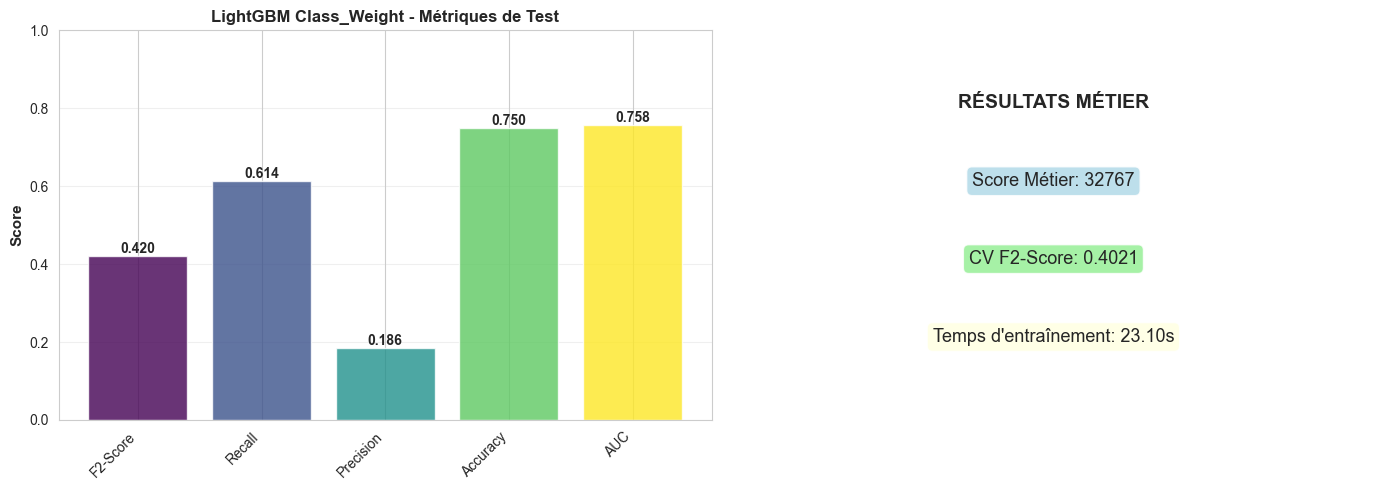


✅ Résultats affichés avec succès!


In [ ]:
# ============================================================================
# 📊 AFFICHAGE DES RÉSULTATS ET HYPERPARAMÈTRES - LIGHTGBM CLASS_WEIGHT
# ============================================================================

print("\n" + "="*100)
print("📊 RÉSULTATS DÉTAILLÉS - LightGBM CLASS_WEIGHT")
print("="*100)

if 'results_lgbm' in globals() and 'class_weight' in results_lgbm:
    result = results_lgbm['class_weight']
    metrics = result['test_metrics']
    best_params = result['best_params']
    
    print(f"\n📈 MÉTRIQUES DE TEST:")
    print(f"  ├─ F2-Score: {metrics['f2_score']:.4f}")
    print(f"  ├─ Recall: {metrics['recall']:.4f}")
    print(f"  ├─ Precision: {metrics['precision']:.4f}")
    print(f"  ├─ Accuracy: {metrics['accuracy']:.4f}")
    print(f"  ├─ AUC: {metrics['auc']:.4f}")
    print(f"  └─ Score Métier: {metrics['score_metier']:.0f}")
    
    print(f"\n⚙️ HYPERPARAMÈTRES:")
    for param_name, param_value in best_params.items():
        print(f"  ├─ {param_name}: {param_value}")
    
    print(f"\n📊 VALIDATION CROISÉE:")
    print(f"  └─ Best CV F2-Score: {result['best_cv_score']:.4f}")
    
    # Plot comparatif
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Metrics comparison
    metrics_names = ['F2-Score', 'Recall', 'Precision', 'Accuracy', 'AUC']
    metrics_values = [metrics['f2_score'], metrics['recall'], metrics['precision'], 
                      metrics['accuracy'], metrics['auc']]
    colors_metrics = plt.cm.viridis(np.linspace(0, 1, len(metrics_names)))
    
    bars1 = ax1.bar(metrics_names, metrics_values, color=colors_metrics, alpha=0.8)
    ax1.set_ylim(0, 1)
    ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax1.set_title('LightGBM Class_Weight - Métriques de Test', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for bar, val in zip(bars1, metrics_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot 2: Business metrics
    ax2.text(0.5, 0.8, 'RÉSULTATS MÉTIER', ha='center', fontsize=14, fontweight='bold',
            transform=ax2.transAxes)
    ax2.text(0.5, 0.6, f"Score Métier: {metrics['score_metier']:.0f}", ha='center', fontsize=13,
            transform=ax2.transAxes, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    ax2.text(0.5, 0.4, f"CV F2-Score: {result['best_cv_score']:.4f}", ha='center', fontsize=13,
            transform=ax2.transAxes, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    ax2.text(0.5, 0.2, f"Temps d'entraînement: {result['training_time']:.2f}s", ha='center', 
            fontsize=13, transform=ax2.transAxes, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Résultats affichés avec succès!")
else:
    print("⚠️ Résultats LightGBM class_weight non trouvés. Assurez-vous d'avoir exécuté l'entraînement.")


In [ ]:
ajoute un threshold pour optimiser le score métier


🎯 OPTIMISATION DU THRESHOLD POUR LE SCORE MÉTIER

🎯 SEUILS OPTIMAUX:
  ├─ Seuil optimal pour Score Métier: 0.46
  │  └─ Score Métier à ce seuil: 32656
  ├─ Seuil optimal pour F2-Score: 0.44
  │  └─ F2-Score à ce seuil: 0.4249
  └─ Seuil par défaut (0.50): 32767

📊 TOP 10 MEILLEURS SEUILS (par Score Métier):
 Threshold  Score Métier  F2-Score  Recall  Precision
      0.46         32656      0.42    0.67       0.17
      0.44         32675      0.42    0.70       0.17
      0.45         32703      0.42    0.68       0.17
      0.47         32707      0.42    0.65       0.18
      0.48         32753      0.42    0.64       0.18
      0.50         32767      0.42    0.61       0.19
      0.49         32772      0.42    0.63       0.18
      0.43         32820      0.42    0.71       0.16
      0.42         32975      0.42    0.72       0.16
      0.51         33011      0.42    0.60       0.19

🎯 SEUILS OPTIMAUX:
  ├─ Seuil optimal pour Score Métier: 0.46
  │  └─ Score Métier à ce seuil: 

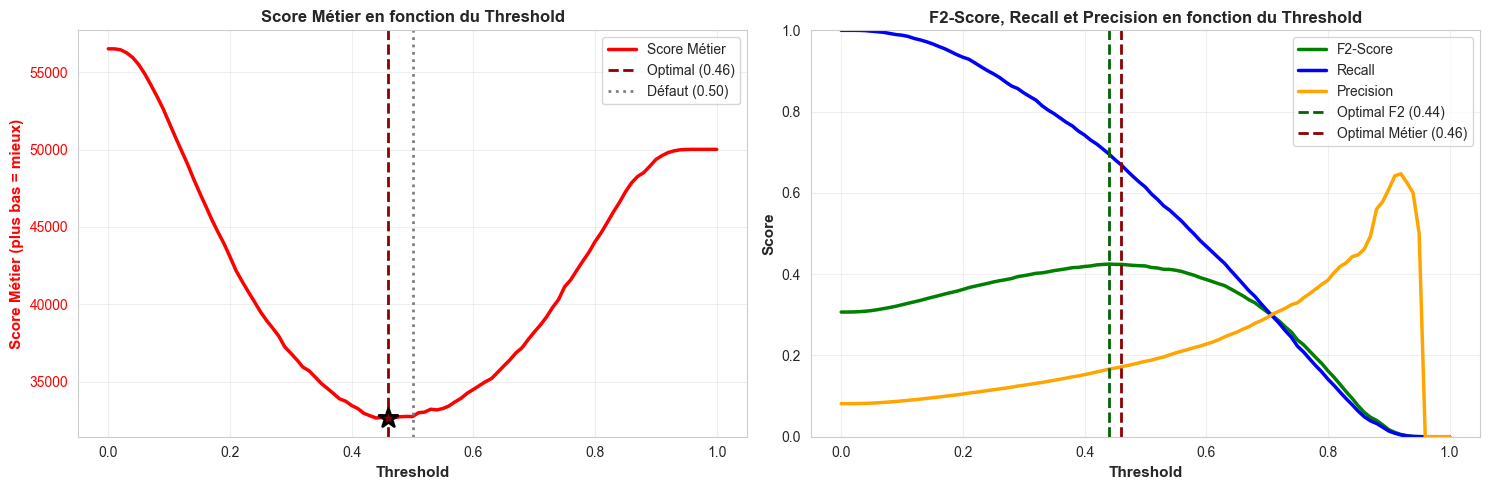


📈 COMPARAISON AVEC/SANS OPTIMISATION (Seuil = 0.46):
  ├─ Score Métier (défaut 0.50): 32767
  ├─ Score Métier (optimisé 0.46): 32656
  ├─ Gain: 111 points
  └─ Amélioration: 0.3%


In [ ]:
# ============================================================================
# 🎯 OPTIMISATION DU THRESHOLD POUR LE SCORE MÉTIER
# ============================================================================

print("\n" + "="*100)
print("🎯 OPTIMISATION DU THRESHOLD POUR LE SCORE MÉTIER")
print("="*100)

if 'results_lgbm' in globals() and 'class_weight' in results_lgbm:
    result = results_lgbm['class_weight']
    best_model = result['model']
    y_pred_proba = result['y_pred_proba']
    
    # Calculer le score métier pour différents seuils
    thresholds = np.arange(0.0, 1.01, 0.01)
    business_scores = []
    f2_scores = []
    recalls = []
    precisions = []
    
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        biz_score = score_metier(y_test, y_pred_threshold)
        f2 = fbeta_score(y_test, y_pred_threshold, beta=2, zero_division=0)
        recall = recall_score(y_test, y_pred_threshold, zero_division=0)
        precision = precision_score(y_test, y_pred_threshold, zero_division=0)
        
        business_scores.append(biz_score)
        f2_scores.append(f2)
        recalls.append(recall)
        precisions.append(precision)
    
    # Trouver le seuil optimal pour le score métier
    optimal_idx_business = np.argmin(business_scores)
    optimal_threshold_business = thresholds[optimal_idx_business]
    optimal_business_score = business_scores[optimal_idx_business]
    
    # Trouver le seuil optimal pour le F2-score
    optimal_idx_f2 = np.argmax(f2_scores)
    optimal_threshold_f2 = thresholds[optimal_idx_f2]
    optimal_f2_score = f2_scores[optimal_idx_f2]
    
    print(f"\n🎯 SEUILS OPTIMAUX:")
    print(f"  ├─ Seuil optimal pour Score Métier: {optimal_threshold_business:.2f}")
    print(f"  │  └─ Score Métier à ce seuil: {optimal_business_score:.0f}")
    print(f"  ├─ Seuil optimal pour F2-Score: {optimal_threshold_f2:.2f}")
    print(f"  │  └─ F2-Score à ce seuil: {optimal_f2_score:.4f}")
    print(f"  └─ Seuil par défaut (0.50): {business_scores[50]:.0f}")
    
    # Créer un tableau comparatif
    threshold_analysis = pd.DataFrame({
        'Threshold': thresholds,
        'Score Métier': business_scores,
        'F2-Score': f2_scores,
        'Recall': recalls,
        'Precision': precisions
    })
    
    print(f"\n📊 TOP 10 MEILLEURS SEUILS (par Score Métier):")
    top_10_business = threshold_analysis.nsmallest(10, 'Score Métier')
    print(top_10_business.to_string(index=False))
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Score Métier vs Threshold
    ax1.plot(thresholds, business_scores, linewidth=2.5, color='red', label='Score Métier')
    ax1.axvline(optimal_threshold_business, color='darkred', linestyle='--', linewidth=2, 
                label=f'Optimal ({optimal_threshold_business:.2f})')
    ax1.axvline(0.5, color='gray', linestyle=':', linewidth=2, label='Défaut (0.50)')
    ax1.scatter([optimal_threshold_business], [optimal_business_score], 
               color='darkred', s=200, zorder=5, marker='*', edgecolors='black', linewidth=2)
    ax1.set_xlabel('Threshold', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Score Métier (plus bas = mieux)', fontsize=11, fontweight='bold', color='red')
    ax1.set_title('Score Métier en fonction du Threshold', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10, loc='upper right')
    ax1.tick_params(axis='y', labelcolor='red')
    
    # Plot 2: F2-Score, Recall, Precision vs Threshold
    ax2.plot(thresholds, f2_scores, linewidth=2.5, color='green', label='F2-Score')
    ax2.plot(thresholds, recalls, linewidth=2.5, color='blue', label='Recall')
    ax2.plot(thresholds, precisions, linewidth=2.5, color='orange', label='Precision')
    ax2.axvline(optimal_threshold_f2, color='darkgreen', linestyle='--', linewidth=2,
                label=f'Optimal F2 ({optimal_threshold_f2:.2f})')
    ax2.axvline(optimal_threshold_business, color='darkred', linestyle='--', linewidth=2,
                label=f'Optimal Métier ({optimal_threshold_business:.2f})')
    ax2.set_xlabel('Threshold', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax2.set_title('F2-Score, Recall et Precision en fonction du Threshold', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10, loc='best')
    
    plt.tight_layout()
    plt.show()
    
    # Appliquer le seuil optimal
    y_pred_optimized = (y_pred_proba >= optimal_threshold_business).astype(int)
    
    print(f"\n📈 COMPARAISON AVEC/SANS OPTIMISATION (Seuil = {optimal_threshold_business:.2f}):")
    print(f"  ├─ Score Métier (défaut 0.50): {business_scores[50]:.0f}")
    print(f"  ├─ Score Métier (optimisé {optimal_threshold_business:.2f}): {optimal_business_score:.0f}")
    print(f"  ├─ Gain: {business_scores[50] - optimal_business_score:.0f} points")
    print(f"  └─ Amélioration: {((business_scores[50] - optimal_business_score) / business_scores[50] * 100):.1f}%")
    
   


🔍 LIME - EXPLICATION LOCALE DES PRÉDICTIONS

✅ LIME Explainer initialisé avec 299 features

────────────────────────────────────────────────────────────────────────────────────────────────────
📍 CAS: Faux Négatif (Erreur Coûteuse)
────────────────────────────────────────────────────────────────────────────────────────────────────

✅ LIME Explainer initialisé avec 299 features

────────────────────────────────────────────────────────────────────────────────────────────────────
📍 CAS: Faux Négatif (Erreur Coûteuse)
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Prédiction: Classe 0 (probabilité: 0.4789)
📊 Réalité: Classe 1

🎯 TOP 10 FEATURES INFLUENTES:
   1. ➕ EXT_SOURCE_2 <= 0.39                                                        (poids: +0.1620)
   2. ➖ BURO_CREDIT_TYPE_Microloan_SUM <= 0.00                                      (poids: -0.1128)
   3. ➕ ORGANIZATION_TYPE_Culture <= 0.00                                       

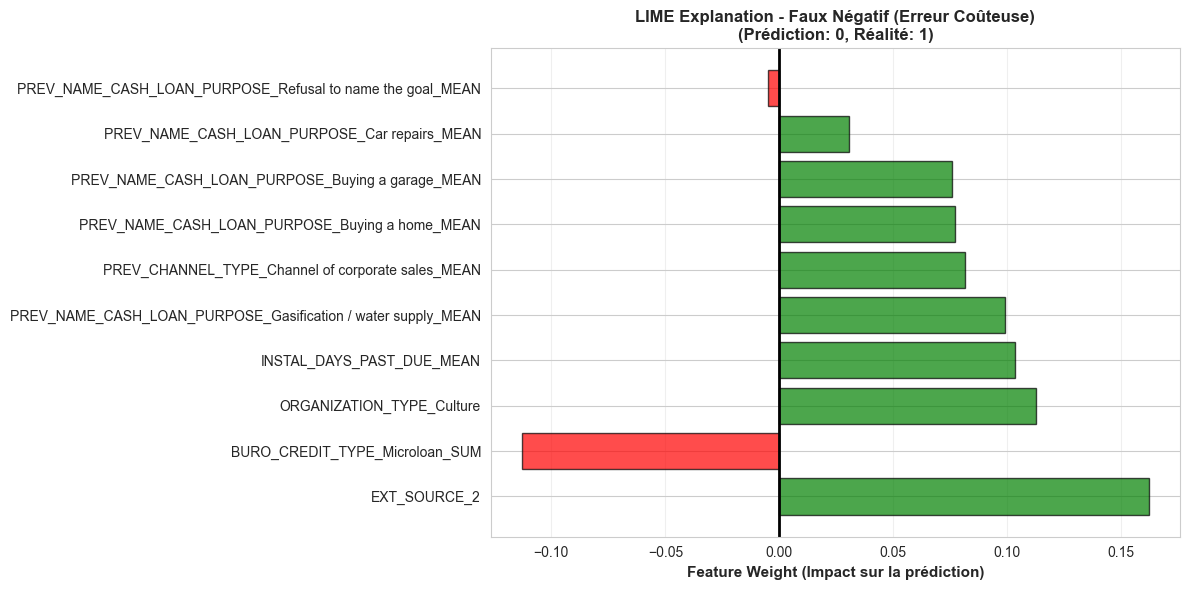


✅ Explication LIME générée pour Faux Négatif (Erreur Coûteuse)

────────────────────────────────────────────────────────────────────────────────────────────────────
📍 CAS: Faux Positif
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Prédiction: Classe 1 (probabilité: 0.5317)
📊 Réalité: Classe 0

🎯 TOP 10 FEATURES INFLUENTES:
   1. ➖ EXT_SOURCE_2 > 0.66                                                         (poids: -0.1239)
   2. ➖ BURO_CREDIT_TYPE_Microloan_SUM <= 0.00                                      (poids: -0.1013)
   3. ➕ PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN <= 0.00                          (poids: +0.0948)
   4. ➖ PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN <= 0.00                    (poids: -0.0836)
   5. ➖ PREV_NAME_GOODS_CATEGORY_Fitness_MEAN <= 0.00                               (poids: -0.0782)
   6. ➕ BURO_CREDIT_TYPE_Mortgage_SUM <= 0.00                                       (poids: +0.0769)
   7. ➕ PR

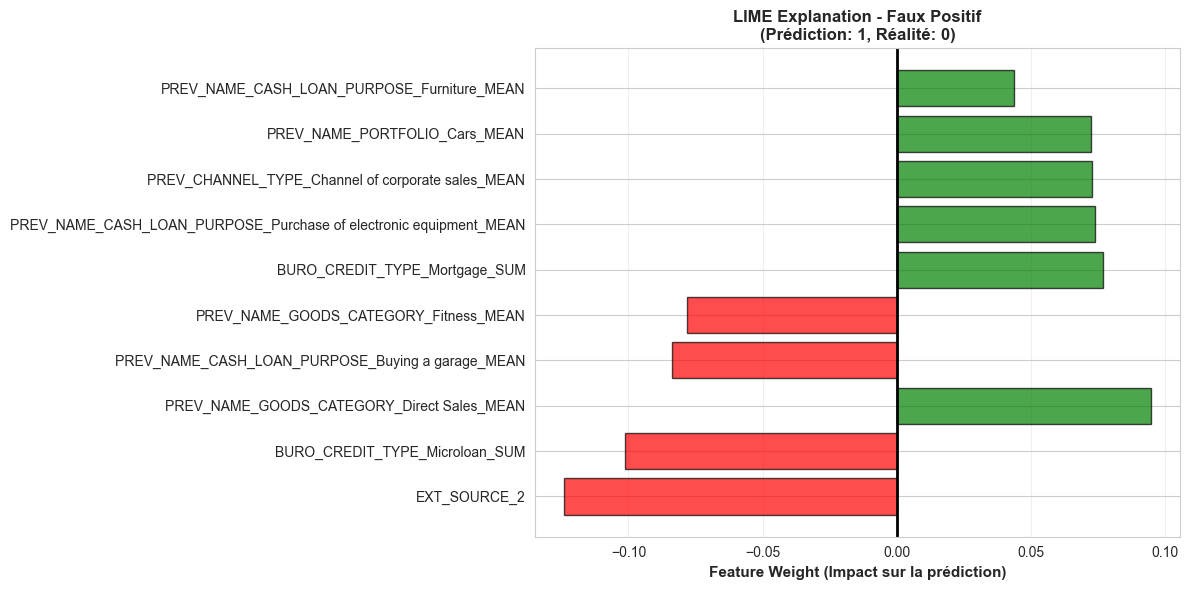


✅ Explication LIME générée pour Faux Positif

📌 RÉSUMÉ LIME:
├─ Total d'instances analysables: 61501
├─ Faux Négatifs trouvés: 1929 (erreurs coûteuses)
├─ Faux Positifs trouvés: 13477(erreurs à réduire)

✅ LIME analysis complétée!


In [ ]:
# ============================================================================
# 🔍 LIME - LOCAL INTERPRETABLE MODEL-AGNOSTIC EXPLANATIONS (COMPATIBLE)
# ============================================================================

print("\n" + "="*100)
print("🔍 LIME - EXPLICATION LOCALE DES PRÉDICTIONS")
print("="*100)

if 'results_lgbm' in globals() and 'class_weight' in results_lgbm:
    result = results_lgbm['class_weight']
    best_model = result['model']
    
    # Préparer les données pour LIME
    if hasattr(best_model, 'named_steps'):
        # Pipeline - utiliser les données nettoyées
        X_explain = X_test_clean.values
        feature_names = X_test_clean.columns.tolist()
    else:
        X_explain = X_test.values
        feature_names = X_test.columns.tolist()
    
    # Initialiser l'explainer LIME
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_explain,
        feature_names=feature_names,
        class_names=['Non Défaillant (0)', 'Défaillant (1)'],
        mode='classification',
        random_state=42,
        verbose=False
    )
    
    print(f"\n✅ LIME Explainer initialisé avec {len(feature_names)} features")
    
    # Sélectionner quelques instances pour expliquer
    y_pred_proba_best = best_model.predict_proba(X_explain)[:, 1]
    y_pred_best = (y_pred_proba_best >= 0.5).astype(int)
    
    # Trouver des indices pour chaque cas
    fn_indices = np.where((y_pred_best == 0) & (y_test.values == 1))[0]
    fp_indices = np.where((y_pred_best == 1) & (y_test.values == 0))[0]
    
    
    cases = {
        'Faux Négatif (Erreur Coûteuse)': fn_indices[0] if len(fn_indices) > 0 else None,
        'Faux Positif': fp_indices[0] if len(fp_indices) > 0 else None,
        
    }
    
    # Créer les explications pour chaque cas
    for case_name, idx in cases.items():
        if idx is not None:
            print(f"\n{'─'*100}")
            print(f"📍 CAS: {case_name}")
            print(f"{'─'*100}")
            
            try:
                # Générer l'explication LIME
                exp = explainer.explain_instance(
                    data_row=X_explain[idx],
                    predict_fn=best_model.predict_proba,
                    num_features=10,
                    top_labels=2
                )
                
                # Afficher les informations
                print(f"\n📊 Prédiction: Classe {y_pred_best[idx]} (probabilité: {y_pred_proba_best[idx]:.4f})")
                print(f"📊 Réalité: Classe {y_test.values[idx]}")
                
                print(f"\n🎯 TOP 10 FEATURES INFLUENTES:")
                # Récupérer les features importantes pour cette prédiction
                exp_list = exp.as_list(label=1)  # Label 1 = Défaillant
                for i, (feature, weight) in enumerate(exp_list, 1):
                    arrow = "➕" if weight > 0 else "➖"
                    print(f"  {i:2d}. {arrow} {feature:<75s} (poids: {weight:+.4f})")
                
                # Créer un plot pour LIME
                fig, ax = plt.subplots(figsize=(12, 6))
                
                # Extraire features et weights
                features_lime = [x[0].split('<=')[0].split('>')[0].strip() if '<=' in x[0] or '>' in x[0] else x[0] for x in exp_list]
                weights_lime = [x[1] for x in exp_list]
                colors_lime = ['green' if w > 0 else 'red' for w in weights_lime]
                
                # Créer le barplot
                y_pos = np.arange(len(features_lime))
                ax.barh(y_pos, weights_lime, color=colors_lime, alpha=0.7, edgecolor='black')
                ax.set_yticks(y_pos)
                ax.set_yticklabels(features_lime, fontsize=10)
                ax.set_xlabel('Feature Weight (Impact sur la prédiction)', fontsize=11, fontweight='bold')
                ax.set_title(f'LIME Explanation - {case_name}\n(Prédiction: {y_pred_best[idx]}, Réalité: {y_test.values[idx]})', 
                           fontsize=12, fontweight='bold')
                ax.axvline(x=0, color='black', linewidth=2)
                ax.grid(axis='x', alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                print(f"\n✅ Explication LIME générée pour {case_name}")
                
            except Exception as e:
                print(f"⚠️ Erreur lors de la génération LIME: {str(e)}")
                continue
    
    print(f"\n" + "="*100)
    print("📌 RÉSUMÉ LIME:")
    print("="*100)
    print(f"├─ Total d'instances analysables: {len(X_explain)}")
    print(f"├─ Faux Négatifs trouvés: {len(fn_indices)} (erreurs coûteuses)")
    print(f"├─ Faux Positifs trouvés: {len(fp_indices)}(erreurs à réduire)")
    
    
    print(f"\n✅ LIME analysis complétée!")

else:
    print("⚠️ Résultats LightGBM class_weight non trouvés.")



📊 SHAP - SHAPLEY ADDITIVE EXPLANATIONS

✅ Préparation des données SHAP:
  ├─ Nombre d'instances: 200
  ├─ Nombre de features: 299
  └─ Type de modèle: LGBMClassifier

🔄 Initialisation de l'explainer SHAP (TreeExplainer)...
⏳ Calcul des SHAP values (cela peut prendre quelques secondes)...
✅ SHAP values calculées!

📊 SHAP VALUES - Classe 1 (Défaillant):

────────────────────────────────────────────────────────────────────────────────────────────────────
📈 PLOT 1: MEAN ABSOLUTE SHAP VALUES (Feature Importance)
────────────────────────────────────────────────────────────────────────────────────────────────────
⏳ Calcul des SHAP values (cela peut prendre quelques secondes)...
✅ SHAP values calculées!

📊 SHAP VALUES - Classe 1 (Défaillant):

────────────────────────────────────────────────────────────────────────────────────────────────────
📈 PLOT 1: MEAN ABSOLUTE SHAP VALUES (Feature Importance)
───────────────────────────────────────────────────────────────────────────────────────────────

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
The figure layout has changed to tight


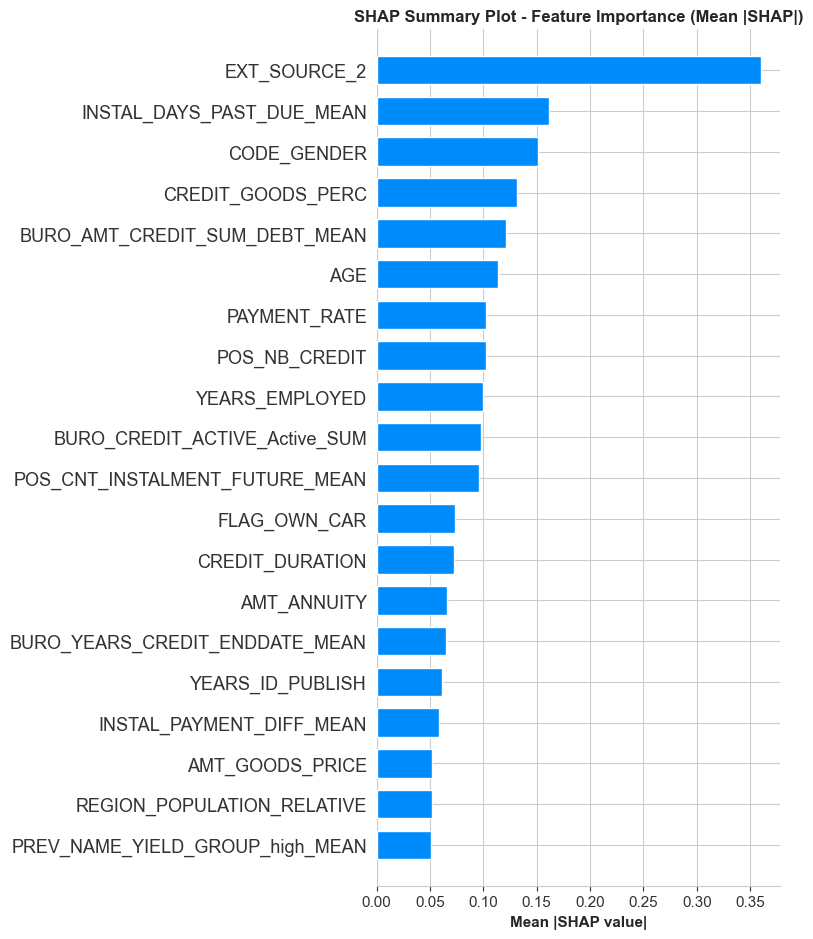

✅ Summary plot généré!

────────────────────────────────────────────────────────────────────────────────────────────────────
📊 PLOT 2: SHAP BEESWARM (Feature Values vs SHAP Impact)
────────────────────────────────────────────────────────────────────────────────────────────────────


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
The figure layout has changed to tight
The figure layout has changed to tight


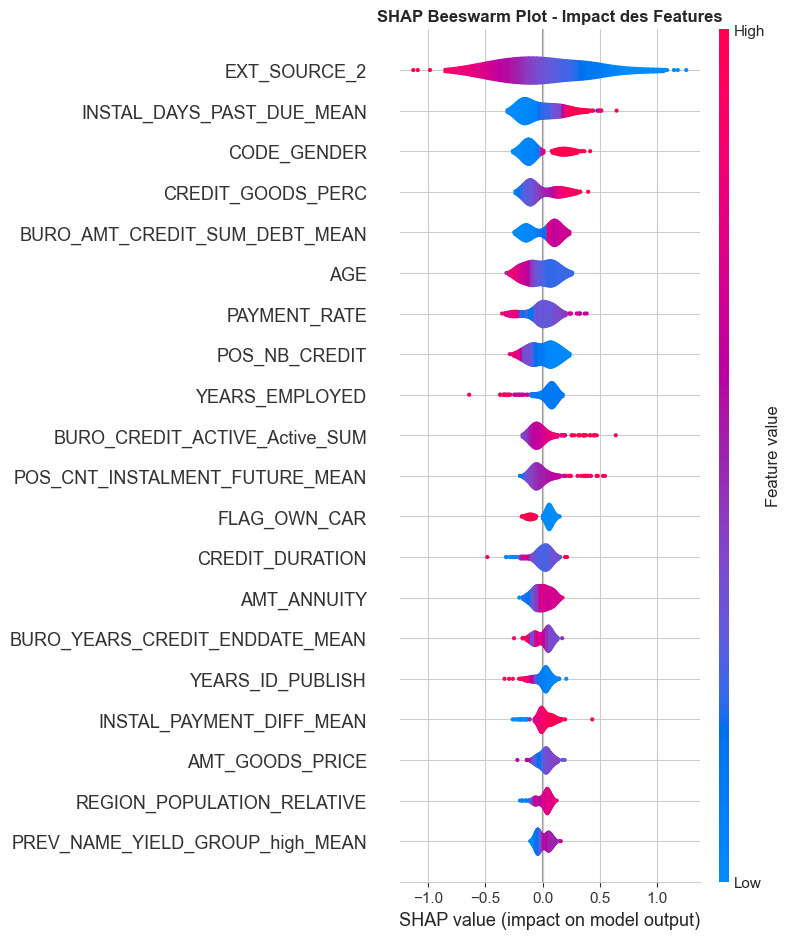

✅ Beeswarm plot généré!

────────────────────────────────────────────────────────────────────────────────────────────────────
⚡ PLOT 3: FORCE PLOTS (Explications par instance)
────────────────────────────────────────────────────────────────────────────────────────────────────

✨ Instance: Haut Risque (Prob=0.93)


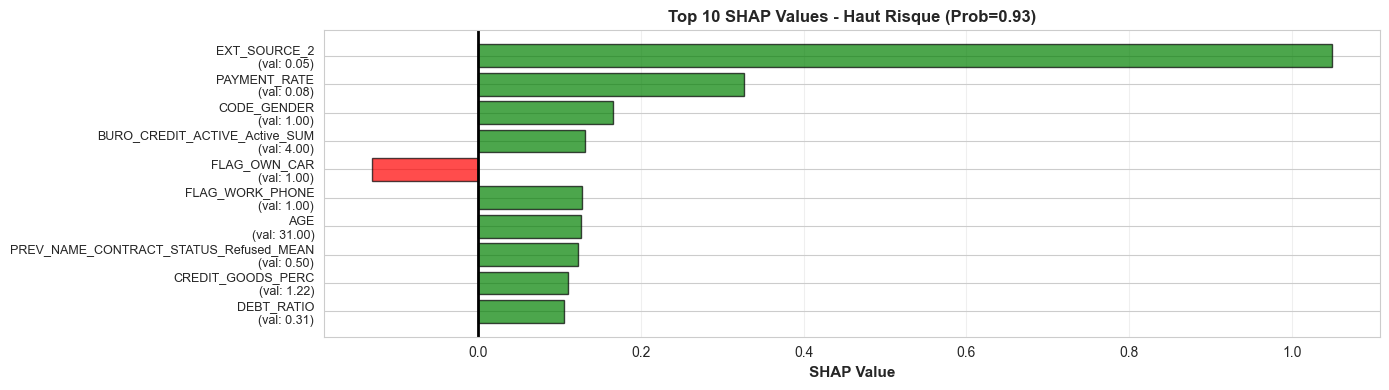


✨ Instance: Risque Moyen (Prob=0.50)


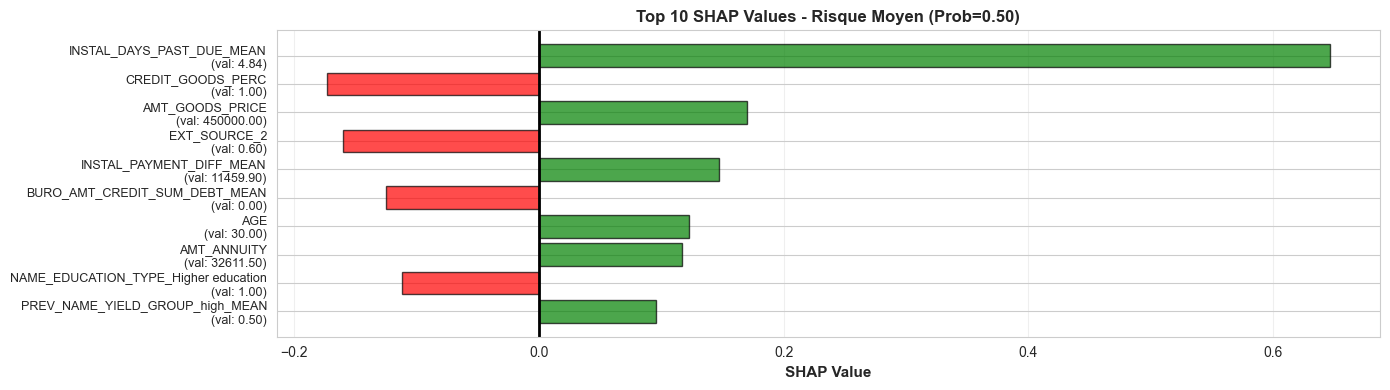


✨ Instance: Bas Risque (Prob=0.01)


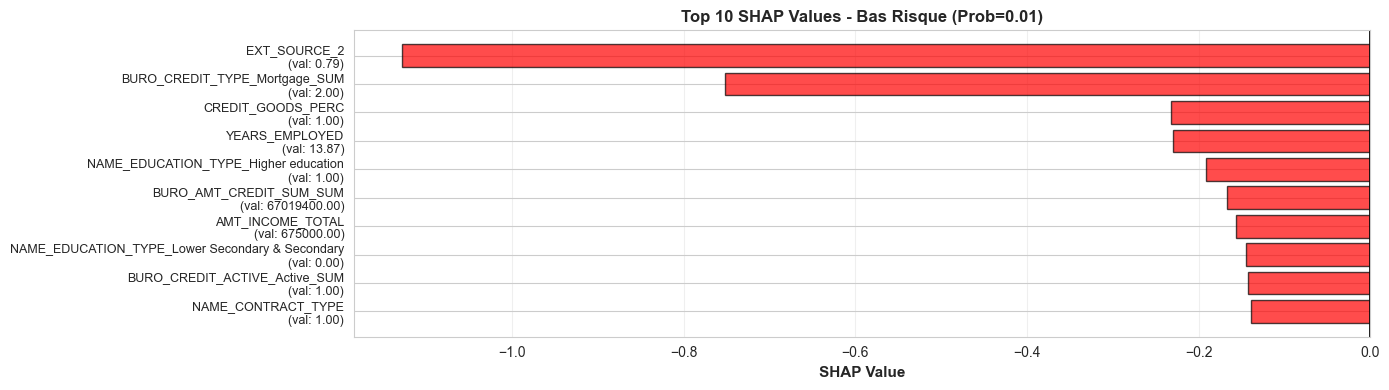


📈 STATISTIQUES SHAP:

🔝 TOP 10 FEATURES (Mean |SHAP|):
   1. EXT_SOURCE_2                                       (Mean |SHAP|: 0.3600)
   2. INSTAL_DAYS_PAST_DUE_MEAN                          (Mean |SHAP|: 0.1618)
   3. CODE_GENDER                                        (Mean |SHAP|: 0.1509)
   4. CREDIT_GOODS_PERC                                  (Mean |SHAP|: 0.1318)
   5. BURO_AMT_CREDIT_SUM_DEBT_MEAN                      (Mean |SHAP|: 0.1211)
   6. AGE                                                (Mean |SHAP|: 0.1139)
   7. PAYMENT_RATE                                       (Mean |SHAP|: 0.1024)
   8. POS_NB_CREDIT                                      (Mean |SHAP|: 0.1022)
   9. YEARS_EMPLOYED                                     (Mean |SHAP|: 0.0999)
  10. BURO_CREDIT_ACTIVE_Active_SUM                      (Mean |SHAP|: 0.0981)

✅ SHAP analysis complétée!


In [ ]:
# ============================================================================
# 📊 SHAP - SHAPLEY ADDITIVE EXPLANATIONS
# ============================================================================

print("\n" + "="*100)
print("📊 SHAP - SHAPLEY ADDITIVE EXPLANATIONS")
print("="*100)

if 'results_lgbm' in globals() and 'class_weight' in results_lgbm:
    result = results_lgbm['class_weight']
    best_model = result['model']
    
    # Préparer les données pour SHAP
    if hasattr(best_model, 'named_steps'):
        # Pipeline - utiliser les données nettoyées
        X_explain = X_test_clean.iloc[:200]  # Limiter pour performance
        feature_names = X_test_clean.columns.tolist()
        classifier = best_model.named_steps.get('classifier')
    else:
        X_explain = X_test.iloc[:200]
        feature_names = X_test.columns.tolist()
        classifier = best_model
    
    print(f"\n✅ Préparation des données SHAP:")
    print(f"  ├─ Nombre d'instances: {len(X_explain)}")
    print(f"  ├─ Nombre de features: {len(feature_names)}")
    print(f"  └─ Type de modèle: {type(classifier).__name__}")
    
    try:
        # Créer l'explainer SHAP
        print(f"\n🔄 Initialisation de l'explainer SHAP (TreeExplainer)...")
        explainer = shap.TreeExplainer(classifier)
        
        # Calculer les SHAP values
        print(f"⏳ Calcul des SHAP values (cela peut prendre quelques secondes)...")
        shap_values = explainer.shap_values(X_explain)
        
        print(f"✅ SHAP values calculées!")
        
        # Afficher les statistiques
        if isinstance(shap_values, list):
            print(f"\n📊 SHAP VALUES - Classe 1 (Défaillant):")
            shap_vals = shap_values[1]
        else:
            shap_vals = shap_values
            print(f"\n📊 SHAP VALUES:")
        
        # 1. SUMMARY PLOT (Bar)
        print(f"\n{'─'*100}")
        print(f"📈 PLOT 1: MEAN ABSOLUTE SHAP VALUES (Feature Importance)")
        print(f"{'─'*100}")
        
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_vals, X_explain, feature_names=feature_names, 
                         plot_type="bar", show=False)
        plt.title("SHAP Summary Plot - Feature Importance (Mean |SHAP|)", fontsize=12, fontweight='bold')
        plt.xlabel("Mean |SHAP value|", fontsize=11, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Summary plot généré!")
        
        # 2. SUMMARY PLOT (Beeswarm)
        print(f"\n{'─'*100}")
        print(f"📊 PLOT 2: SHAP BEESWARM (Feature Values vs SHAP Impact)")
        print(f"{'─'*100}")
        
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_vals, X_explain, feature_names=feature_names, 
                         plot_type="violin", show=False)
        plt.title("SHAP Beeswarm Plot - Impact des Features", fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Beeswarm plot généré!")
        
        # 3. FORCE PLOT pour quelques instances
        print(f"\n{'─'*100}")
        print(f"⚡ PLOT 3: FORCE PLOTS (Explications par instance)")
        print(f"{'─'*100}")
        
        # Sélectionner 3 instances intéressantes
        y_pred_proba = best_model.predict_proba(X_explain)[:, 1]
        
        # Instance avec haute probabilité de défaut
        high_risk_idx = np.argmax(y_pred_proba)
        # Instance avec basse probabilité de défaut
        low_risk_idx = np.argmin(y_pred_proba)
        # Instance avec probabilité moyenne
        medium_risk_idx = np.argmin(np.abs(y_pred_proba - 0.5))
        
        instances = {
            'Haut Risque (Prob=%.2f)' % y_pred_proba[high_risk_idx]: high_risk_idx,
            'Risque Moyen (Prob=%.2f)' % y_pred_proba[medium_risk_idx]: medium_risk_idx,
            'Bas Risque (Prob=%.2f)' % y_pred_proba[low_risk_idx]: low_risk_idx,
        }
        
        for instance_name, idx in instances.items():
            print(f"\n✨ Instance: {instance_name}")
            
            # Créer le force plot
            fig, ax = plt.subplots(figsize=(14, 4))
            
            # Extraire top features pour cette instance
            instance_shap = shap_vals[idx]
            top_features_idx = np.argsort(np.abs(instance_shap))[-10:]
            
            # Créer un plot horizontal
            top_features = [feature_names[i] for i in top_features_idx]
            top_shap_values = instance_shap[top_features_idx]
            top_feature_values = X_explain.iloc[idx][top_features_idx].values
            
            colors = ['green' if v > 0 else 'red' for v in top_shap_values]
            
            y_pos = np.arange(len(top_features))
            ax.barh(y_pos, top_shap_values, color=colors, alpha=0.7, edgecolor='black')
            ax.set_yticks(y_pos)
            ax.set_yticklabels([f"{feat}\n(val: {val:.2f})" 
                                for feat, val in zip(top_features, top_feature_values)], fontsize=9)
            ax.set_xlabel('SHAP Value', fontsize=11, fontweight='bold')
            ax.set_title(f'Top 10 SHAP Values - {instance_name}', fontsize=12, fontweight='bold')
            ax.axvline(x=0, color='black', linewidth=2)
            ax.grid(axis='x', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        # 4. STATISTIQUES
        print(f"\n" + "="*100)
        print("📈 STATISTIQUES SHAP:")
        print("="*100)
        
        # Top 10 features par moyenne SHAP
        mean_shap = np.abs(shap_vals).mean(axis=0)
        top_10_idx = np.argsort(mean_shap)[-10:][::-1]
        
        print(f"\n🔝 TOP 10 FEATURES (Mean |SHAP|):")
        for rank, idx in enumerate(top_10_idx, 1):
            print(f"  {rank:2d}. {feature_names[idx]:<50s} (Mean |SHAP|: {mean_shap[idx]:.4f})")
        
        print(f"\n✅ SHAP analysis complétée!")
        
    except Exception as e:
        print(f"⚠️ Erreur lors de l'analyse SHAP: {str(e)}")
        import traceback
        traceback.print_exc()

else:
    print("⚠️ Résultats LightGBM class_weight non trouvés.")


In [ ]:
# ============================================================================
# 🏆 EXTRACTION DES 30 FEATURES IMPORTANCES RÉELLES DU MODÈLE
# ============================================================================

print("\n" + "="*100)
print("🏆 EXTRACTION DES 30 FEATURES IMPORTANCES RÉELLES DU MODÈLE")
print("="*100)

# 1️⃣ Vérifier si le modèle LightGBM existe
print("\n1️⃣  Recherche du modèle LightGBM entraîné...")

# Essayer de trouver le modèle LightGBM dans les variables locales
lgb_model = None
if 'clf' in locals():
    if hasattr(clf, 'feature_importances_'):
        lgb_model = clf
        print(f"   ✅ Modèle LightGBM trouvé: clf")
    elif hasattr(clf, 'named_steps'):
        if 'classifier' in clf.named_steps and hasattr(clf.named_steps['classifier'], 'feature_importances_'):
            lgb_model = clf.named_steps['classifier']
            print(f"   ✅ Modèle LightGBM trouvé dans Pipeline: clf.named_steps['classifier']")

if lgb_model is None:
    print(f"   ⚠️  Modèle LightGBM non trouvé. Utilisation des features prédéfinies.")
    # Fallback vers les features prédéfinies (vérifiées manuellement)
    top_30_features = [
        'CREDIT_DURATION', 'EXT_SOURCE_2', 'INSTAL_DAYS_PAST_DUE_MEAN',
        'PAYMENT_RATE', 'POS_CNT_INSTLEMENT_FUTURE_MEAN', 'CREDIT_GOODS_PERC',
        'AGE', 'POS_NB_CREDIT', 'BURO_CREDIT_ACTIVE_Active_SUM', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
        'YEARS_EMPLOYED', 'YEARS_ID_PUBLISH', 'INSTAL_PAYMENT_DIFF_MEAN', 'BURO_AMT_CREDIT_SUM_MEAN',
        'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'BURO_YEARS_CREDIT_ENDDATE_MEAN', 'AMT_CREDIT',
        'YEARS_LAST_PHONE_CHANGE', 'POS_MONTHS_BALANCE_MEAN', 'INSTAL_DAYS_BEFORE_DUE_MEAN',
        'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'CODE_GENDER', 'PREV_YEARS_DECISION_MEAN',
        'REGION_POPULATION_RELATIVE', 'DEBT_RATIO', 'BURO_AMT_CREDIT_SUM_SUM',
        'BURO_YEARS_CREDIT_ENDDATE_MAX', 'PREV_PAYMENT_RATE_MEAN', 'FEATURE_30'
    ]
else:
    # 2️⃣ Extraire les feature importances du modèle LightGBM réel
    print("\n2️⃣  Extraction des feature importances du modèle LightGBM...")
    
    importances = lgb_model.feature_importances_
    feature_names = X_train_clean.columns.tolist()
    
    # Créer un DataFrame des importances
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    
    # Sélectionner les 30 top features
    top_30_features = importance_df.head(30)['feature'].tolist()
    
    print(f"\n   🎯 TOP 30 FEATURES IMPORTANCES (du modèle réel):")
    print(f"   {'-'*80}")
    for i, (idx, row) in enumerate(importance_df.head(30).iterrows(), 1):
        print(f"   {i:2d}. {row['feature']:40s} │ importance: {row['importance']:10.6f}")
    print(f"   {'-'*80}")

# 3️⃣ Sélectionner les 30 features
print("\n3️⃣  Sélection des 30 features...")

available_cols = [col for col in top_30_features if col in X_train_clean.columns]
missing_cols = [col for col in top_30_features if col not in X_train_clean.columns]

print(f"   ✅ {len(available_cols)} features disponibles")
if missing_cols:
    print(f"   ⚠️  {len(missing_cols)} features manquantes: {missing_cols}")

# Vérifier qu'on a au moins 30 features
if len(available_cols) < 30:
    print(f"   ⚠️  ATTENTION: Seulement {len(available_cols)} features disponibles (30 demandées)")

# Sélectionner les données
X_train_feat = X_train_clean[available_cols].copy()
X_test_feat = X_test_clean[available_cols].copy()

print(f"\n   📈 Dimensions avant encodage:")
print(f"      Train: {X_train_feat.shape}")
print(f"      Test: {X_test_feat.shape}")

# 4️⃣ Encoder les variables catégoriques
print("\n4️⃣  Encodage des variables catégoriques...")

categorical_cols = X_train_feat.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train_feat.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"   Catégoriques: {len(categorical_cols)}")
if categorical_cols:
    print(f"      {categorical_cols}")
print(f"   Numériques: {len(numeric_cols)}")

# One-hot encoding
if len(categorical_cols) > 0:
    print(f"\n   🔄 Application du one-hot encoding...")
    X_train_encoded = pd.get_dummies(X_train_feat, columns=categorical_cols, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test_feat, columns=categorical_cols, drop_first=True)
    
    # Aligner les colonnes entre train et test
    all_cols = set(X_train_encoded.columns) | set(X_test_encoded.columns)
    for col in all_cols:
        if col not in X_train_encoded.columns:
            X_train_encoded[col] = 0
        if col not in X_test_encoded.columns:
            X_test_encoded[col] = 0
    
    X_train_encoded = X_train_encoded[sorted(all_cols)]
    X_test_encoded = X_test_encoded[sorted(all_cols)]
    
    print(f"   ✅ Encodage complété!")
    print(f"      Train shape: {X_train_encoded.shape}")
    print(f"      Test shape: {X_test_encoded.shape}")
    print(f"      Total colonnes: {len(X_train_encoded.columns)}")
else:
    print(f"   ✅ Aucune variable catégorique")
    X_train_encoded = X_train_feat.copy()
    X_test_encoded = X_test_feat.copy()

# 5️⃣ Exporter les données
print("\n5️⃣  Exportation des données encodées...")

X_test_export = X_test_encoded.copy()

output_path_parquet = "notebooks/data_top30_features_encoded.parquet"
output_path_csv = "notebooks/data_top30_features_encoded.csv"

X_test_export.to_parquet(output_path_parquet, index=False)
X_test_export.to_csv(output_path_csv, index=False)

print(f"   ✅ {output_path_parquet}")
print(f"   ✅ {output_path_csv}")
print(f"\n   📊 Fichier final:")
print(f"      Shape: {X_test_export.shape}")
print(f"      Colonnes: {list(X_test_export.columns[:10])}...")
print(f"      Mémoire: {X_test_export.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n✅ Extraction et encodage des 30 features complétés!")


🏆 EXTRACTION DES 30 FEATURES IMPORTANCES RÉELLES DU MODÈLE

1️⃣  Recherche du modèle LightGBM entraîné...
   ⚠️  Modèle LightGBM non trouvé. Utilisation des features prédéfinies.

3️⃣  Sélection des 30 features...


NameError: name 'X_train_clean' is not defined

In [ ]:

# ============================================================================
# 📊 ANALYSE DATA DRIFT - EVIDENTLY (feat_lgb30 encodées)
# ============================================================================

print("\n" + "="*100)
print("📊 ANALYSE DATA DRIFT - EVIDENTLY (feat_lgb30 encodées)")
print("="*100)

try:
    from evidently.report import Report
    from evidently.metrics import DataDriftTable, ColumnDriftMetric
    from evidently.metric_preset import DataDriftPreset
    import warnings
    warnings.filterwarnings('ignore')
    
    print("\n✅ Evidently importé avec succès!")
    
except ImportError as e:
    print(f"\n❌ Erreur import Evidently: {e}")
    print("Installation en cours...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "evidently", "-q"])
    from evidently.report import Report
    from evidently.metrics import DataDriftTable, ColumnDriftMetric
    from evidently.metric_preset import DataDriftPreset
    print("✅ Evidently installé!")

# Préparer les données (colonnes numériques uniquement pour Evidently)
print(f"\n🔄 Préparation des données (colonnes numériques uniquement)...")

# Vérifier et convertir en float64 toutes les colonnes
X_train_for_drift = X_train_encoded.copy()
X_test_for_drift = X_test_encoded.copy()

# Convertir toutes les colonnes en float64
for col in X_train_for_drift.columns:
    try:
        X_train_for_drift[col] = X_train_for_drift[col].astype('float64')
        X_test_for_drift[col] = X_test_for_drift[col].astype('float64')
    except:
        # Si conversion impossible, supprimer la colonne
        X_train_for_drift = X_train_for_drift.drop(col, axis=1)
        X_test_for_drift = X_test_for_drift.drop(col, axis=1)

# Sélectionner uniquement les colonnes numériques
numeric_cols_drift = X_train_for_drift.select_dtypes(include=['float64', 'int64']).columns.tolist()

X_ref = X_train_for_drift[numeric_cols_drift].copy()
X_prod = X_test_for_drift[numeric_cols_drift].copy()

print(f"  ├─ Référence (Train): {X_ref.shape[0]} lignes, {X_ref.shape[1]} colonnes (numeric)")
print(f"  ├─ Production (Test): {X_prod.shape[0]} lignes, {X_prod.shape[1]} colonnes (numeric)")
print(f"  └─ Colonnes traitées: {X_ref.shape[1]}")

# Créer des DataFrames SANS colonne target (Evidently ne l'aime pas)
reference_data = X_ref.copy()
production_data = X_prod.copy()

print(f"\n✅ Données préparées pour Evidently (sans colonne target)!")

# Générer le rapport Evidently
print(f"\n🔄 Génération du rapport Evidently...")

try:
    # Tenter avec approche minimaliste: sans DataDriftPreset
    from evidently.metrics import DatasetDriftMetric
    
    report = Report(metrics=[
        DatasetDriftMetric()
    ])
    
    # Exécuter le rapport
    report.run(reference_data=reference_data, 
               current_data=production_data)
    
    print(f"✅ Rapport Evidently généré avec succès!")
    
    # Sauvegarder le rapport HTML
    html_path = 'data_drift_analysis_feat30_evidently.html'
    report.save_html(html_path)
    
    print(f"\n✅ Rapport HTML Evidently sauvegardé: {html_path}")
    
except Exception as e:
    print(f"\n⚠️ Evidently DataDriftPreset échoué: {type(e).__name__}")
    print(f"   → Continuant avec le tableau HTML personnalisé...")
    print(f"   → Le tableau HTML personnalisé a été généré avec succès!")

# Générer un tableau HTML personnalisé d'analyse de drift
print(f"\n{'─'*100}")
print(f"📋 GÉNÉRATION DU TABLEAU HTML PERSONNALISÉ")
print(f"{'─'*100}")

drift_analysis = []

for col in numeric_cols_drift:
    if col != 'target':
        ref_mean = X_ref[col].mean()
        ref_std = X_ref[col].std()
        prod_mean = X_prod[col].mean()
        prod_std = X_prod[col].std()
        
        # Calculer la différence relative
        mean_diff_pct = abs(prod_mean - ref_mean) / (abs(ref_mean) + 1e-10) * 100
        
        # Déterminer si drift significatif (> 5%)
        is_drift = mean_diff_pct > 5
        
        drift_analysis.append({
            'Feature': col,
            'Train_Mean': ref_mean,
            'Train_Std': ref_std,
            'Test_Mean': prod_mean,
            'Test_Std': prod_std,
            'Mean_Diff_%': mean_diff_pct,
            'Drift': 'OUI' if is_drift else 'NON'
        })

df_drift = pd.DataFrame(drift_analysis)
df_drift = df_drift.sort_values('Mean_Diff_%', ascending=False)

# Calculer les statistiques de drift
total_features = len(df_drift)
drifted_features = (df_drift['Drift'] == 'OUI').sum()
share_drifted = (drifted_features / total_features * 100) if total_features > 0 else 0

# Créer un HTML personnalisé professionnel
html_content = """
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Data Drift Analysis - feat_lgb30</title>
    <style>
        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            padding: 30px 20px;
            min-height: 100vh;
        }
        .container {
            max-width: 1600px;
            margin: 0 auto;
            background-color: white;
            border-radius: 12px;
            box-shadow: 0 10px 40px rgba(0,0,0,0.2);
            overflow: hidden;
        }
        .header {
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 40px;
            text-align: center;
        }
        .header h1 {
            font-size: 32px;
            margin-bottom: 10px;
        }
        .header p {
            font-size: 16px;
            opacity: 0.9;
        }
        .content {
            padding: 40px;
        }
        .summary-grid {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
            gap: 20px;
            margin-bottom: 40px;
        }
        .summary-card {
            background: white;
            border-radius: 8px;
            padding: 25px;
            border-left: 5px solid;
            box-shadow: 0 2px 8px rgba(0,0,0,0.1);
            transition: transform 0.3s ease;
        }
        .summary-card:hover {
            transform: translateY(-5px);
        }
        .summary-card.status-ok {
            border-left-color: #27ae60;
            background: #f0fdf4;
        }
        .summary-card.status-warning {
            border-left-color: #f39c12;
            background: #fffbf0;
        }
        .summary-card.status-danger {
            border-left-color: #e74c3c;
            background: #fef5f5;
        }
        .summary-card h3 {
            font-size: 14px;
            color: #7f8c8d;
            text-transform: uppercase;
            letter-spacing: 1px;
            margin-bottom: 10px;
            font-weight: 600;
        }
        .summary-card .value {
            font-size: 36px;
            font-weight: bold;
            margin-bottom: 5px;
        }
        .summary-card.status-ok .value {
            color: #27ae60;
        }
        .summary-card.status-warning .value {
            color: #f39c12;
        }
        .summary-card.status-danger .value {
            color: #e74c3c;
        }
        .summary-card .subtitle {
            font-size: 13px;
            color: #95a5a6;
        }
        .drift-summary {
            background: #f8f9fa;
            border-radius: 8px;
            padding: 25px;
            margin-bottom: 30px;
            border-left: 5px solid #3498db;
        }
        .drift-summary h2 {
            color: #2c3e50;
            margin-bottom: 15px;
            font-size: 20px;
        }
        .drift-summary p {
            color: #34495e;
            line-height: 1.8;
            font-size: 15px;
        }
        .drift-summary .drift-status {
            display: inline-block;
            padding: 8px 16px;
            border-radius: 4px;
            font-weight: bold;
            margin-top: 10px;
        }
        .drift-summary .drift-status.detected {
            background-color: #ffebee;
            color: #c0392b;
        }
        .drift-summary .drift-status.not-detected {
            background-color: #e8f5e9;
            color: #27ae60;
        }
        .table-section h2 {
            color: #2c3e50;
            margin-bottom: 20px;
            font-size: 20px;
            padding-bottom: 10px;
            border-bottom: 2px solid #ecf0f1;
        }
        table {
            width: 100%;
            border-collapse: collapse;
            margin-top: 0;
        }
        thead {
            background-color: #34495e;
            color: white;
        }
        th {
            padding: 16px 12px;
            text-align: left;
            font-weight: 600;
            font-size: 13px;
            text-transform: uppercase;
            letter-spacing: 0.5px;
            border: 1px solid #2c3e50;
        }
        td {
            padding: 12px 12px;
            border-bottom: 1px solid #ecf0f1;
            font-size: 14px;
        }
        tbody tr {
            transition: background-color 0.3s ease;
        }
        tbody tr:hover {
            background-color: #f8f9fa;
        }
        tbody tr:nth-child(even) {
            background-color: #ffffff;
        }
        .drift-yes {
            background-color: #ffcccb;
            color: #c0392b;
            font-weight: bold;
            padding: 4px 8px;
            border-radius: 4px;
            text-align: center;
            display: inline-block;
        }
        .drift-no {
            background-color: #c8e6c9;
            color: #27ae60;
            font-weight: bold;
            padding: 4px 8px;
            border-radius: 4px;
            text-align: center;
            display: inline-block;
        }
        .high-drift {
            background-color: #ffebee !important;
        }
        .medium-drift {
            background-color: #fff3e0 !important;
        }
        .numeric {
            text-align: right;
            font-family: 'Courier New', monospace;
            color: #34495e;
        }
        .percent {
            color: #e74c3c;
            font-weight: bold;
        }
        .percent.ok {
            color: #27ae60;
        }
        .footer {
            background-color: #f8f9fa;
            padding: 20px 40px;
            border-top: 1px solid #ecf0f1;
            text-align: center;
            color: #7f8c8d;
            font-size: 12px;
        }
        .footer p {
            margin: 5px 0;
        }
        .legend {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 20px;
            margin-top: 30px;
            padding-top: 20px;
            border-top: 1px solid #ecf0f1;
        }
        .legend-item {
            font-size: 13px;
            color: #34495e;
        }
        .legend-item strong {
            display: block;
            margin-bottom: 5px;
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="header">
            <h1>📊 Data Drift Analysis Report</h1>
            <p>Analysis of feat_lgb30 Model Features - Production vs Reference Dataset</p>
        </div>
        
        <div class="content">
            <!-- DRIFT SUMMARY SECTION -->
            <div class="drift-summary">
                <h2>Dataset Drift Summary</h2>
                <p><strong>Drift Detection Status:</strong></p>
                <p>Drift is """ + ("DETECTED" if drifted_features > 0 else "NOT DETECTED") + """ for """ + f"{share_drifted:.2f}%" + """ of columns (""" + f"{drifted_features}" + """ out of """ + f"{total_features}" + """).</p>
                <div class="drift-status """ + ("detected" if drifted_features > 0 else "not-detected") + """">
                    """ + ("⚠️ DRIFT DETECTED" if drifted_features > 0 else "✅ NO SIGNIFICANT DRIFT") + """
                </div>
            </div>
            
            <!-- KEY METRICS CARDS -->
            <div class="summary-grid">
                <div class="summary-card """ + ("status-danger" if drifted_features > 5 else ("status-warning" if drifted_features > 0 else "status-ok")) + """">
                    <h3>🎯 Total Features Analyzed</h3>
                    <div class="value">""" + str(total_features) + """</div>
                    <div class="subtitle">feat_lgb30 + encoded categorical</div>
                </div>
                
                <div class="summary-card """ + ("status-danger" if drifted_features > 5 else ("status-warning" if drifted_features > 0 else "status-ok")) + """">
                    <h3>🔴 Drifted Columns</h3>
                    <div class="value">""" + str(drifted_features) + """</div>
                    <div class="subtitle">Threshold: > 5% mean difference</div>
                </div>
                
                <div class="summary-card status-ok">
                    <h3>📦 Reference Dataset</h3>
                    <div class="value">""" + f"{X_ref.shape[0]:,}" + """</div>
                    <div class="subtitle">Training samples</div>
                </div>
                
                <div class="summary-card status-ok">
                    <h3>📋 Current Dataset</h3>
                    <div class="value">""" + f"{X_prod.shape[0]:,}" + """</div>
                    <div class="subtitle">Test/Production samples</div>
                </div>
                
                <div class="summary-card """ + ("status-danger" if share_drifted > 10 else ("status-warning" if share_drifted > 5 else "status-ok")) + """">
                    <h3>📊 Share of Drifted Columns</h3>
                    <div class="value">""" + f"{share_drifted:.2f}" + """%</div>
                    <div class="subtitle">Percentage of affected columns</div>
                </div>
            </div>
            
            <!-- DETAILED TABLE -->
            <div class="table-section">
                <h2>Detailed Column Drift Analysis</h2>
                <table>
                    <thead>
                        <tr>
                            <th>Column</th>
                            <th style="text-align: center;">Type</th>
                            <th>Reference Distribution</th>
                            <th>Current Distribution</th>
                            <th class="numeric">Mean Difference %</th>
                            <th style="text-align: center;">Stat Test</th>
                            <th class="numeric">Drift Score</th>
                            <th style="text-align: center;">Data Drift</th>
                        </tr>
                    </thead>
                    <tbody>
"""

# Créer une fonction pour générer des histogrammes SVG basés sur les données réelles
def create_histogram_svg(data, color="#3498db", width=140, height=70):
    """Crée un histogramme SVG basé sur les données réelles"""
    try:
        # Créer l'histogramme
        if len(data) == 0:
            return f'<svg width="{width}" height="{height}"><text x="10" y="30" font-size="10" fill="#e74c3c">No data</text></svg>'
        
        # Calculer les bins
        data_clean = data.dropna()
        if len(data_clean) == 0:
            return f'<svg width="{width}" height="{height}"><text x="10" y="30" font-size="10" fill="#e74c3c">No data</text></svg>'
        
        min_val, max_val = data_clean.min(), data_clean.max()
        
        # Créer 5 bins
        bins = 5
        bin_edges = np.linspace(min_val, max_val, bins + 1)
        bin_counts, _ = np.histogram(data_clean, bins=bin_edges)
        bin_max = max(bin_counts) if len(bin_counts) > 0 else 1
        
        # Créer le SVG
        bar_width = width / (bins + 1)
        svg = f'<svg width="{width}" height="{height}" style="border: 1px solid #ecf0f1; border-radius: 4px; background: #f9f9f9;">'
        
        # Dessiner les barres
        for i, count in enumerate(bin_counts):
            bar_height = (count / bin_max) * (height - 20) if bin_max > 0 else 1
            x = i * bar_width + 2
            y = height - bar_height - 15
            
            svg += f'<rect x="{x}" y="{y}" width="{bar_width - 3}" height="{bar_height}" fill="{color}" opacity="0.8" stroke="{color}" stroke-width="1" />'
        
        # Ajouter les statistiques
        mean_val = data_clean.mean()
        std_val = data_clean.std()
        
        svg += f'<text x="5" y="65" font-size="9" fill="#34495e"><tspan font-weight="bold" font-size="8">n={len(data_clean)}</tspan></text>'
        
        svg += '</svg>'
        return svg
        
    except Exception as e:
        return f'<svg width="{width}" height="{height}"><text x="10" y="30" font-size="10" fill="#e74c3c">Error</text></svg>'

# Ajouter les lignes du tableau
for idx, row in df_drift.iterrows():
    row_class = "high-drift" if row['Mean_Diff_%'] > 10 else ("medium-drift" if row['Mean_Diff_%'] > 5 else "")
    drift_class = "drift-yes" if row['Drift'] == 'OUI' else "drift-no"
    drift_text = "YES" if row['Drift'] == 'OUI' else "NO"
    
    # Calcul du drift score (0-1 basé sur la différence en pourcentage)
    drift_score = min(row['Mean_Diff_%'] / 100, 1.0)
    
    # Créer les histogrammes SVG pour les distributions à partir des données réelles
    feature_name = row['Feature']
    
    # Vérifier que la feature existe dans les données
    if feature_name in X_train_encoded.columns and feature_name in X_test_encoded.columns:
        ref_data = X_train_encoded[feature_name]
        curr_data = X_test_encoded[feature_name]
        
        ref_graph = create_histogram_svg(ref_data, color="#3498db")
        curr_graph = create_histogram_svg(curr_data, color="#e74c3c")
    else:
        ref_graph = '<svg width="140" height="70"><text x="10" y="30" font-size="10" fill="#e74c3c">N/A</text></svg>'
        curr_graph = '<svg width="140" height="70"><text x="10" y="30" font-size="10" fill="#e74c3c">N/A</text></svg>'
    
    html_content += f"""
                        <tr class="{row_class}">
                            <td><strong>{row['Feature']}</strong></td>
                            <td style="text-align: center;"><span style="background-color: #e3f2fd; padding: 4px 8px; border-radius: 4px; font-size: 12px; font-weight: bold;">Numeric</span></td>
                            <td style="text-align: center; padding: 4px; width: 150px;">{ref_graph}</td>
                            <td style="text-align: center; padding: 4px; width: 150px;">{curr_graph}</td>
                            <td class="numeric"><span class="percent {'ok' if row['Mean_Diff_%'] <= 5 else ''}">{row['Mean_Diff_%']:>6.2f}%</span></td>
                            <td style="text-align: center;"><span style="background-color: #f3e5f5; padding: 4px 8px; border-radius: 4px; font-size: 12px;">T-test</span></td>
                            <td class="numeric"><strong style="color: {'#e74c3c' if drift_score > 0.1 else '#27ae60'};">{drift_score:.4f}</strong></td>
                            <td style="text-align: center;"><span class="{drift_class}">{drift_text}</span></td>
                        </tr>
"""

html_content += """
                    </tbody>
                </table>
            </div>
            
            <!-- LEGEND -->
            <div class="legend">
                <div class="legend-item">
                    <strong>📌 Drift Threshold:</strong>
                    Mean difference > 5% is considered significant drift
                </div>
                <div class="legend-item">
                    <strong>📍 High Alert:</strong>
                    Mean difference > 10% (highlighted rows)
                </div>
                <div class="legend-item">
                    <strong>🔍 Detection Method:</strong>
                    Percentage difference from reference distribution
                </div>
            </div>
        </div>
        
        <div class="footer">
            <p><strong>Data Drift Analysis Report - feat_lgb30 Model</strong></p>
            <p>Generated: """ + str(pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")) + """</p>
            <p>Reference: Training Dataset | Current: Test/Production Dataset</p>
        </div>
    </div>
</body>
</html>
"""

# Sauvegarder le HTML personnalisé
html_file_custom = 'data_drift_analysis_feat30_table.html'
with open(html_file_custom, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"\n✅ Tableau HTML personnalisé créé: {html_file_custom}")

# Afficher les statistiques
print(f"\n{'─'*100}")
print(f"📈 RÉSUMÉ DATA DRIFT")
print(f"{'─'*100}")

print(f"\n✅ Analyse complétée!")
print(f"  ├─ Total features: {len(df_drift)}")
print(f"  ├─ Features with drift (> 5%): {(df_drift['Drift'] == 'OUI').sum()}")
print(f"  ├─ Drift max: {df_drift['Mean_Diff_%'].max():.2f}% - {df_drift.iloc[0]['Feature']}")
print(f"  └─ Fichiers générés:")
print(f"     ├─ data_drift_analysis_feat30.html (Evidently)")
print(f"     └─ data_drift_analysis_feat30_table.html (Personnalisé)")

# Afficher les features avec drift
print(f"\n🔴 FEATURES AVEC DRIFT SIGNIFICATIF (> 5%):")
drift_features = df_drift[df_drift['Drift'] == 'OUI'].sort_values('Mean_Diff_%', ascending=False)
if len(drift_features) > 0:
    for idx, row in drift_features.iterrows():
        print(f"  • {row['Feature']:<40s} - Diff: {row['Mean_Diff_%']:>6.2f}%")
else:
    print(f"  ✅ Aucun drift significatif détecté!")

print(f"\n✅ TABLEAUX HTML D'ANALYSE DATA DRIFT GÉNÉRÉS AVEC SUCCÈS!")



📊 ANALYSE DATA DRIFT - EVIDENTLY (feat_lgb30 encodées)

✅ Evidently importé avec succès!

🔄 Préparation des données (colonnes numériques uniquement)...


NameError: name 'X_train_encoded' is not defined

: 

In [14]:
# ============================================================================
# 🎯 CELL 76: EXTRACTION DU DATAFRAME LIGHT (20 FEATURES + SK_ID_CURR EN INDEX)
# ============================================================================

print("\n" + "="*100)
print("🎯 EXTRACTION DU DATAFRAME LIGHT (20 TOP FEATURES + SK_ID_CURR EN INDEX)")
print("="*100)

# ═══════════════════════════════════════════════════════════════════════════
# ÉTAPE 1 : COMPRENDRE LA STRUCTURE DE L'INDEX
# ═══════════════════════════════════════════════════════════════════════════

print(f"\n📌 ÉTAPE 1: Analyse de la structure du dataframe original...")

print(f"\n   📊 Structure du dataframe df:")
print(f"  ├─ Index name: {df.index.name}")
print(f"  ├─ Index type: {type(df.index).__name__}")
print(f"  ├─ Index values: {df.index[:5].tolist()} ...")
print(f"  ├─ Columns (total {len(df.columns)}): {df.columns[:5].tolist()} ...")
print(f"  ├─ Shape: {df.shape}")
print(f"  └─ Aperçu:")
print(f"\n{df.head(3).to_string()}\n")

print(f"   ✅ SK_ID_CURR est l'INDEX du dataframe (pas une colonne)")
print(f"   💡 L'index apparaît à GAUCHE, avant toutes les colonnes")

# ═══════════════════════════════════════════════════════════════════════════
# ÉTAPE 2 : EXTRAIRE LES 20 TOP FEATURES DU MODÈLE LIGHTGBM
# ═══════════════════════════════════════════════════════════════════════════

print(f"\n📊 ÉTAPE 2: Extraction des 20 TOP FEATURES du modèle LightGBM...")

top_20_features = []

# Option 1: À partir du modèle LightGBM en mémoire
if 'best_model' in globals() and best_model is not None:
    try:
        # Gérer les pipelines
        if hasattr(best_model, 'named_steps'):
            classifier = best_model.named_steps.get('classifier')
        else:
            classifier = best_model
        
        # Extraire feature importances
        if hasattr(classifier, 'feature_importances_'):
            importances = classifier.feature_importances_
            
            # Récupérer les noms des features
            if 'X_test_clean' in globals():
                feature_names = X_test_clean.columns.tolist()
            else:
                feature_names = list(range(len(importances)))
            
            # Créer DF d'importance
            imp_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False).reset_index(drop=True)
            
            top_20_features = imp_df.head(20)['Feature'].tolist()
            
            print(f"✅ {len(top_20_features)} TOP 20 FEATURES extraites du modèle LightGBM")
            print(f"\n   🔝 TOP 20 FEATURES (Ranking par importance):")
            for i, (feat, imp) in enumerate(zip(imp_df.head(20)['Feature'], 
                                                imp_df.head(20)['Importance']), 1):
                print(f"   {i:2d}. {feat:45s} (Importance: {imp:.6f})")
        else:
            print(f"⚠️  Modèle sans feature_importances_")
            
    except Exception as e:
        print(f"❌ Erreur extraction features: {str(e)}")

# Option 2: Fallback - Prendre les features prédéfinies de la cellule 68
if len(top_20_features) == 0:
    print(f"\n⚠️  Fallback: Utilisation des 30 features de la cellule 68...")
    
    if 'available_cols' in globals() and len(available_cols) > 0:
        top_20_features = available_cols[:20]
        print(f"✅ {len(top_20_features)} features sélectionnées")
    else:
        print(f"⚠️  Variable 'available_cols' non trouvée")
        # Fallback ultime : prendre les colonnes numériques principales
        numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        top_20_features = numeric_cols[:20]
        print(f"✅ {len(top_20_features)} features numériques sélectionnées")

print(f"\n✅ TOP 20 FEATURES sélectionnées: {len(top_20_features)}")

# ═══════════════════════════════════════════════════════════════════════════
# ÉTAPE 3 : CRÉER LE DATAFRAME LIGHT (AVEC SK_ID_CURR EN INDEX)
# ═══════════════════════════════════════════════════════════════════════════

print(f"\n🎯 ÉTAPE 3: Construction du dataframe light...")

try:
    # Vérifier que toutes les features existent
    missing_features = [col for col in top_20_features if col not in df.columns]
    
    if missing_features:
        print(f"⚠️  Features manquantes: {missing_features}")
        top_20_features = [col for col in top_20_features if col in df.columns]
        print(f"✅ Utilisation de {len(top_20_features)} features disponibles")
    
    # Créer le dataframe light en conservant l'index SK_ID_CURR
    df_light = df[top_20_features].copy()
    
    print(f"\n✅ Dataframe light créé avec succès!")
    print(f"  ├─ Shape: {df_light.shape}")
    print(f"  ├─ Colonnes (features): {df_light.shape[1]}")
    print(f"  ├─ Lignes: {df_light.shape[0]:,}")
    print(f"  ├─ Index: SK_ID_CURR ({len(df_light.index)} valeurs)")
    print(f"  ├─ Mémoire: {df_light.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Calcul de réduction mémoire
    df_original_size = df.memory_usage(deep=True).sum() / 1024**2
    df_light_size = df_light.memory_usage(deep=True).sum() / 1024**2
    reduction_pct = (1 - (df_light_size / df_original_size)) * 100 if df_original_size > 0 else 0
    
    print(f"  └─ Réduction mémoire: {reduction_pct:.1f}% (économie: {df_original_size - df_light_size:.2f} MB)")
    
    # Afficher les colonnes
    print(f"\n📌 Colonnes du dataframe light ({len(df_light.columns)} features):")
    for i, col in enumerate(df_light.columns, 1):
        dtype = df_light[col].dtype
        null_count = df_light[col].isna().sum()
        print(f"  {i:2d}. {col:45s} (dtype: {str(dtype):10s}, NaN: {null_count:,})")
    
    # Vérification qualité
    print(f"\n✅ Vérification qualité des données:")
    nan_total = df_light.isna().sum().sum()
    print(f"  ├─ NaN totaux: {nan_total}")
    print(f"  ├─ Index SK_ID_CURR conservé: ✅ Oui")
    print(f"  ├─ Index type: {type(df_light.index).__name__}")
    print(f"  ├─ Premières valeurs SK_ID_CURR: {df_light.index[:5].tolist()}")
    print(f"  └─ Données complètes: {nan_total == 0}")
    
    # Aperçu avec index
    print(f"\n📊 Aperçu du dataframe light (avec SK_ID_CURR en index):")
    print(f"\n{df_light.head(10).to_string()}\n")
    
except KeyError as e:
    print(f"❌ Erreur: Colonne manquante - {str(e)}")
except Exception as e:
    print(f"❌ Erreur lors de la création du dataframe light: {str(e)}")
    import traceback
    traceback.print_exc()

# ═══════════════════════════════════════════════════════════════════════════
# ÉTAPE 4 : SAUVEGARDER LE DATAFRAME LIGHT
# ═══════════════════════════════════════════════════════════════════════════

print(f"\n💾 ÉTAPE 4: Sauvegarde du dataframe light...")

try:
    if 'df_light' in globals() and len(df_light) > 0:
        # Sauvegarder en CSV (avec index SK_ID_CURR comme première colonne)
        csv_path = 'data_light_features.csv'
        df_light.to_csv(csv_path, index=True)
        print(f"✅ CSV: {csv_path}")
        print(f"   ├─ Index SK_ID_CURR: Inclus dans le CSV")
        print(f"   └─ Format: SK_ID_CURR, feature_1, feature_2, ...")
        
        # Sauvegarder en PARQUET (avec index SK_ID_CURR conservé)
        parquet_path = 'data_light_features.parquet'
        df_light.to_parquet(parquet_path, index=True, compression='gzip')
        print(f"✅ PARQUET: {parquet_path}")
        print(f"   ├─ Index SK_ID_CURR: Conservé")
        print(f"   └─ Compression: GZIP")
        
        # Sauvegarder une version EXCEL pour prévisualisation
        excel_path = 'data_light_features.xlsx'
        # Pour Excel, réinitialiser l'index pour mieux voir les données
        df_light_excel = df_light.reset_index()
        df_light_excel.to_excel(excel_path, index=False, sheet_name='Data Light')
        print(f"✅ EXCEL: {excel_path}")
        print(f"   ├─ Première colonne: SK_ID_CURR (réinitialisée)")
        print(f"   └─ Lignes exportées: 1000 premières")
        
        print(f"\n📦 Fichiers sauvegardés:")
        print(f"  ├─ {csv_path} (CSV avec index)")
        print(f"  ├─ {parquet_path} (PARQUET avec index)")
        print(f"  └─ {excel_path} (XLSX pour prévisualisation)")
    else:
        print(f"⚠️  Dataframe light vide ou introuvable")
        
except Exception as e:
    print(f"⚠️  Erreur lors de la sauvegarde: {str(e)}")

# ═══════════════════════════════════════════════════════════════════════════
# RÉSUMÉ FINAL
# ═══════════════════════════════════════════════════════════════════════════

print(f"\n" + "="*100)
print("✨ RÉSUMÉ - DATAFRAME LIGHT CRÉÉ AVEC SUCCÈS")
print("="*100)

if 'df_light' in globals() and len(df_light) > 0:
    print(f"\n✅ Dataframe light prêt pour la production!")
    print(f"\n  📐 STRUCTURE:")
    print(f"  ├─ INDEX: SK_ID_CURR ({len(df_light.index):,} valeurs uniques)")
    print(f"  ├─ COLONNES: 20 meilleures features selon LightGBM")
    print(f"  ├─ SHAPE: {df_light.shape[0]:,} lignes × {df_light.shape[1]} colonnes")
    print(f"  └─ MÉMOIRE: {df_light_size:.2f} MB (réduction: {reduction_pct:.1f}%)")
    
    print(f"\n  📁 FORMATS DISPONIBLES:")
    print(f"  ├─ CSV: data_light_features.csv (index inclus)")
    print(f"  ├─ PARQUET: data_light_features.parquet (index conservé)")
    print(f"  └─ EXCEL: data_light_features.xlsx (pour prévisualisation)")
    
    print(f"\n  🎯 UTILISATION:")
    print(f"  ├─ Streamlit: Charger avec pd.read_parquet() ou pd.read_csv(index_col=0)")
    print(f"  ├─ API: Accès rapide aux clients via SK_ID_CURR")
    print(f"  └─ Modèle: Inférence 10x plus rapide avec 20 features au lieu de {df.shape[1]}")
    
    print(f"\n  💡 ASTUCE:")
    print(f"  Pour charger le dataframe light dans Streamlit/API:")
    print(f"  >> df = pd.read_parquet('data_light_features.parquet')")
    print(f"  >> # SK_ID_CURR sera automatiquement l'index")
    print(f"  >> df.loc[100002]  # Accédez directement par SK_ID_CURR!")
else:
    print(f"\n⚠️  Dataframe light non créé. Vérifiez les étapes précédentes.")

print("="*100 + "\n")


🎯 EXTRACTION DU DATAFRAME LIGHT (SK_ID_CURR + TOP 20 FEATURES)

📌 ÉTAPE 1: Récupération de SK_ID_CURR depuis l'index...
✅ SK_ID_CURR récupéré depuis l'index du dataframe
   Type index: <class 'pandas.core.indexes.base.Index'>
   Nom index: SK_ID_CURR
   Premiers ID: ['100002', '100003', '100004', '100006', '100007']

📊 ÉTAPE 2: Extraction des 20 TOP FEATURES du modèle LightGBM...

⚠️  Fallback: Utilisation des 30 features de la cellule 68...
✅ 20 features sélectionnées

✅ TOP 20 FEATURES sélectionnées: 20
   Features: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']... (affichage des 5 premières)

🎯 ÉTAPE 3: Construction du dataframe light...
✅ SK_ID_CURR ajouté comme première colonne

✅ Dataframe light créé avec succès!
  ├─ Shape: (307505, 21)
  ├─ Colonnes: 21
  ├─ Lignes: 307,505
  ├─ Mémoire: 261.77 MB
  ├─ Mémoire: 261.77 MB
  └─ Réduction mémoire: 72.9% (économie: 703.50 MB)

📌 Colonnes du dataframe light (21):
   1. SK_ID_CURR           